In [1]:
# How do similar networks respond to FGSM Attacks from foolbox?
# Classic vs FGN vs Converted+trained

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8.0, 5.0)

In [4]:
import numpy as np

from foolbox import PyTorchModel, accuracy
import foolbox.attacks as fa
import foolbox as fb

import torch
from torch import optim

import copy

In [5]:
# custom library imports
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [6]:
# check gpus
!gpustat

momentsnotice           Fri Nov  6 16:12:59 2020  418.152.00
[0] GeForce GTX 1080 Ti | 77'C,   0 % |  9465 / 11178 MB | salami(9455M)
[1] GeForce GTX 1080 Ti | 87'C, 100 % |  9347 / 11178 MB | salami(9337M)


In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(0)

CUDA Available:  True
Using device: cpu


In [8]:
# get data 
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=10000, 
                                                                                   batch_size_for_val=100000)

# minimum/maximum pixel value post normalization, from train dataset
min_pix = -0.4242129623889923095703125
max_pix =  2.8214867115020751953125000

images, labels = mnist_val_loader.dataset.tensors
images = images.to(device)
labels = labels.to(device)

In [9]:
# load classic model
classic_model_path = "../Experiments/sample_models/sample_classic_full.pth"
classic_model = torch.load(classic_model_path)
classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
# classic model params
!cat '../Experiments/sample_models/sample_FGN_parameters.txt'

hidden_layer_sizes [64, 64]
drop_p 0.2
batch_size 4000
optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
ordinal 2.0
covar_type sphere
lambda for l2 loss 8e-06
lambda for sigma loss 1e-06
non-linearity True


In [11]:
# load an fgn model check same params as FGN
fgn_model_path = '../Experiments/sample_models/sample_FGN_full.pth'
fgn_model = torch.load(fgn_model_path)
fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [12]:
# convert model
fgnl.convert_classic_to_fgn(classic_model, fgn_model, init_factor=1e1, verbose=True)

odict_keys([])

Classic odict_keys(['hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weight', 'hidden_layers.4.bias', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_layers.5.running_mean', 'hidden_layers.5.running_var', 'hidden_layers.5.num_batches_tracked', 'ib.weight', 'ib.bias', 'ib.running_mean', 'ib.running_var', 'ib.num_batches_tracked', 'fl.weight', 'fl.bias'])
FGN odict_keys(['hidden_layers.1.weights', 'hidden_layers.1.biases', 'hidden_layers.1.centers', 'hidden_layers.1.inv_covars', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weights', 'hidden_layers.4.biases', 'hidden_layers.4.centers', 'hidden_layers.4.inv_covars', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_la

In [13]:
# do a quick retrain of the converted model
ret_quick_fgn_model = copy.deepcopy(fgn_model)
ret_quick_fgn_model.to(device)

# define loss
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 1e-7
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, ret_quick_fgn_model.parameters()), lr=1e-3)

# train the network for N epochs
epochs = 1
train_res = fgnh.train(ret_quick_fgn_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 1e-07
Epoch 0 Train set - Average loss: 0.1133, Accuracy: 48408/50000 (97%)
Test set - Average loss: 0.0921, Accuracy: 9748/10000 (97%)


In [14]:
# load heavily retrained model
ret_fgn_model_path = '../Experiments/sample_models/sample_fgn_converted+retrained_full.pth'
ret_fgn_model = torch.load(ret_fgn_model_path)
ret_fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [15]:
# set model bounds and preprocessing

# bounds - I think these might be the bounds:
# inputs ? I think it this
# noise?
# bounds = (-(max_pix-min_pix)/128,(max_pix-min_pix)/128)
bounds = (min_pix+1e-6, max_pix-1e-6)
# preprocessing - I think these would be used in similar way to pytorch preprocessing
# but possible passed to whatever architecture is used (torch, tensorflow, other) 
# in my case the dataloaders already normalizes the data
preprocessing = dict(mean=0, std=1)

In [16]:
# ready the models for foolbox
classic_model.eval()
classic_f_model = PyTorchModel(classic_model, bounds=bounds, device=device)

fgn_model.eval()
fgn_f_model = PyTorchModel(fgn_model, bounds=bounds, device=device)

ret_quick_fgn_model.eval()
ret_quick_fgn_f_model = PyTorchModel(ret_quick_fgn_model, bounds=bounds, device=device)

ret_fgn_model.eval()
ret_fgn_f_model = PyTorchModel(ret_fgn_model, bounds=bounds, device=device)

In [17]:
ret_fgn_f_model.bounds

Bounds(lower=-0.42421196238899234, upper=2.821485711502075)

In [18]:
# check model accuracies
print('accuracies for classic and fgn models')
print(accuracy(classic_f_model, images, labels))
print(accuracy(fgn_f_model, images, labels))
print(accuracy(ret_quick_fgn_f_model, images, labels))
print(accuracy(ret_fgn_f_model, images, labels))

accuracies for classic and fgn models
0.9739000201225281
0.973800003528595
0.9747999906539917
0.9805999994277954


In [19]:
# attack params to explore
epsilons = [(max_pix-min_pix)*x 
            for x in 
            [0.0,
             1/256,
             3/512,
             1/128,
             3/256,
             1/64,
             3/128,
             1/32,
             3/64,
             1/16,
             3/32,
             1/8,
             3/16,
             1/4,
             3/8,
             1/2,
             3/4,
             1.0,] ]

print('epsilons: {}'.format(epsilons))

epsilons: [0.0, 0.012678514351136982, 0.019017771526705474, 0.025357028702273965, 0.03803554305341095, 0.05071405740454793, 0.0760710861068219, 0.10142811480909586, 0.1521421722136438, 0.20285622961819172, 0.3042843444272876, 0.40571245923638344, 0.6085686888545752, 0.8114249184727669, 1.2171373777091503, 1.6228498369455338, 2.4342747554183006, 3.2456996738910675]


In [20]:
# attack the classic model
classic_raw, classic_clipped, classic_adv_success = fa.FGSM()(classic_f_model, images, labels, epsilons=epsilons)

In [21]:
# attack the fgn model
fgn_raw, fgn_clipped, fgn_adv_success = fa.FGSM()(fgn_f_model, images, labels, epsilons=epsilons)

In [22]:
# attack the retrained fgn model
ret_quick_fgn_raw, ret_quick_fgn_clipped, ret_quick_fgn_adv_success = fa.FGSM()(ret_quick_fgn_f_model, images, labels, epsilons=epsilons)

In [23]:
# attack the retrained fgn model
ret_fgn_raw, ret_fgn_clipped, ret_fgn_adv_success = fa.FGSM()(ret_fgn_f_model, images, labels, epsilons=epsilons)

In [24]:
names = ['Classic', 'converted FGN', 'quick retrain FGN', 'long retrain FGN']

Classic Accuracy per epsilon [0.9739 0.1845 0.1348 0.1093 0.0872 0.078  0.0713 0.0669 0.0647 0.0632
 0.0622 0.0612 0.0614 0.0609 0.0606 0.0605 0.0604 0.0604]
FGN Accuracy per epsilon [0.9738 0.1838 0.1348 0.1103 0.087  0.0785 0.0709 0.0666 0.0598 0.0738
 0.0801 0.094  0.076  0.0967 0.0967 0.0967 0.0967 0.1028]
Quick Retrained FGN Accuracy per epsilon [0.9748 0.1839 0.1376 0.1124 0.0863 0.0744 0.0913 0.0917 0.1    0.103
 0.0966 0.0967 0.0967 0.0967 0.0981 0.0961 0.0961 0.0961]
Long Retrained FGN Accuracy per epsilon [0.9806 0.101  0.075  0.0961 0.0961 0.0961 0.0961 0.0961 0.0961 0.0961
 0.0961 0.0961 0.0961 0.0961 0.0961 0.0961 0.0961 0.0961]


<IPython.core.display.Javascript object>


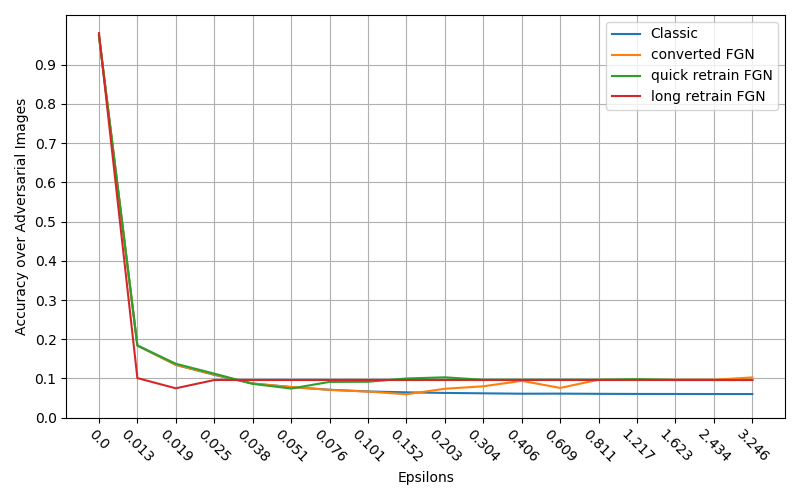

In [25]:
# compare raw success rates
print('Classic Accuracy per epsilon', 1.0 - classic_adv_success.cpu().numpy().mean(axis=-1))
print('FGN Accuracy per epsilon', 1.0 - fgn_adv_success.cpu().numpy().mean(axis=-1))
print('Quick Retrained FGN Accuracy per epsilon', 1.0 - ret_quick_fgn_adv_success.cpu().numpy().mean(axis=-1))
print('Long Retrained FGN Accuracy per epsilon', 1.0 - ret_fgn_adv_success.cpu().numpy().mean(axis=-1))

plt.plot(1.0 - classic_adv_success.cpu().numpy().mean(axis=-1), label=names[0])
plt.plot(1.0 - fgn_adv_success.cpu().numpy().mean(axis=-1), label=names[1])
plt.plot(1.0 - ret_quick_fgn_adv_success.cpu().numpy().mean(axis=-1), label=names[2])
plt.plot(1.0 - ret_fgn_adv_success.cpu().numpy().mean(axis=-1), label=names[3])
plt.legend()
plt.xticks(range(len(epsilons)), labels=np.round(epsilons,3), rotation=-45)
plt.xlabel('Epsilons')
plt.yticks([x/100 for x in range(0,100,10)])
plt.ylabel('Accuracy over Adversarial Images')
plt.tight_layout()
plt.grid()
plt.show()

In [26]:
# extract succesful adv indices
classic_successful_adv_indices = [np.flatnonzero(x) for x in classic_adv_success.cpu().numpy()]
fgn_successful_adv_indices = [np.flatnonzero(x) for x in fgn_adv_success.cpu().numpy()]
ret_quick_fgn_successful_adv_indices = [np.flatnonzero(x) for x in ret_quick_fgn_adv_success.cpu().numpy()]
ret_fgn_successful_adv_indices = [np.flatnonzero(x) for x in ret_fgn_adv_success.cpu().numpy()]

In [27]:
# extract succesful adv raw images
classic_raw_successful = [torch.stack([classic_raw[i][k] for k in j]) 
                          for i,j in enumerate(classic_successful_adv_indices)]
fgn_raw_successful = [torch.stack([fgn_raw[i][k] for k in j])
                      for i,j in enumerate(fgn_successful_adv_indices)]
ret_quick_fgn_raw_successful = [torch.stack([ret_quick_fgn_raw[i][k] for k in j])
                      for i,j in enumerate(ret_quick_fgn_successful_adv_indices)]
ret_fgn_raw_successful = [torch.stack([ret_fgn_raw[i][k] for k in j])
                      for i,j in enumerate(ret_fgn_successful_adv_indices)]

In [28]:
# per epsilon, number of attacks that both:
#  - change the class
#  - have over 0.5 confidence

per_epsilon = []

for i, clipped_images in enumerate(zip(classic_raw_successful, fgn_raw_successful, 
                                       ret_quick_fgn_raw_successful, ret_fgn_raw_successful)):
    
    per_model = [] 
    for n, model in enumerate([classic_model, fgn_model, ret_quick_fgn_model, ret_fgn_model]):
        
        # compute predictions
        model.eval()
        with torch.no_grad(): preds = model(clipped_images[n].to(device))
        preds = preds.cpu().detach().numpy()
        
        # apply softmax for probabilities
        preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])
        # get the maximums
        preds_maxes = np.max(preds_softmax, axis=1)
        
        per_model.append(len([x for x in preds_maxes if x>=0.5 ]))
    per_epsilon.append(per_model)

In [29]:
l = list(zip(*per_epsilon))

In [30]:
np.reshape(l, (3,-1))

array([[ 242, 7459, 7929, 8250, 8589, 8719, 8805, 8850, 8884, 8881, 8863,
        8874, 8892, 8902, 8913, 8919, 8921, 8926,  241, 7436, 7903, 8203,
        8533, 8667],
       [8593, 8470, 7234,  383,    0,    0,    0,    0,    0,    0,    0,
           0,  221, 7229, 7619, 7809, 7819, 7175,  260,    3,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,  173,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]])

<IPython.core.display.Javascript object>


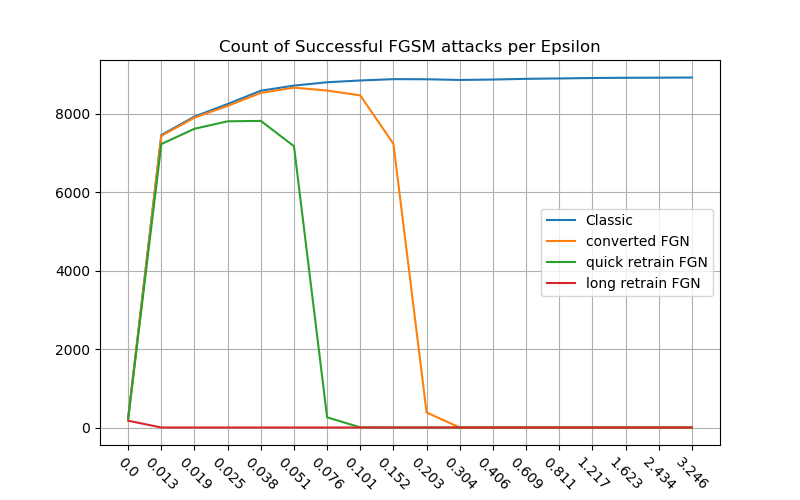

In [31]:
for n, p in enumerate(l):
    plt.plot(p, label=names[n])

plt.legend()
plt.grid()
plt.title('Count of Successful FGSM attacks per Epsilon')
plt.xticks(range(len(epsilons)), labels=np.round(epsilons,3), rotation=-45)
plt.show()

<IPython.core.display.Javascript object>


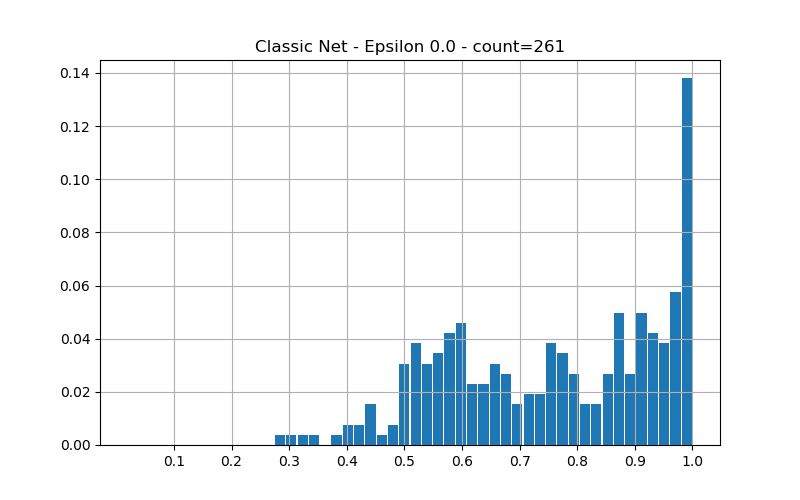

Statistical description of the predictions maximums
DescribeResult(nobs=261, minmax=(0.2911006274555327329, 0.99960376195849921885), mean=0.75990738925871272817, variance=0.03465638944172526875, skewness=-0.33913954701389088632, kurtosis=-1.0657928922617667212)

percentage of confident predictions (>=0.5): 0.9272030651340997

Sample predictions
index 106 prediction [0.   0.   0.   0.92 0.   0.08 0.   0.   0.   0.  ]
index 49 prediction [0.   0.   0.   0.02 0.   0.   0.   0.98 0.   0.  ]
index 40 prediction [0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.  ]
index 196 prediction [0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.98]
index 240 prediction [0.   0.   0.34 0.38 0.   0.   0.   0.26 0.01 0.  ]


<IPython.core.display.Javascript object>


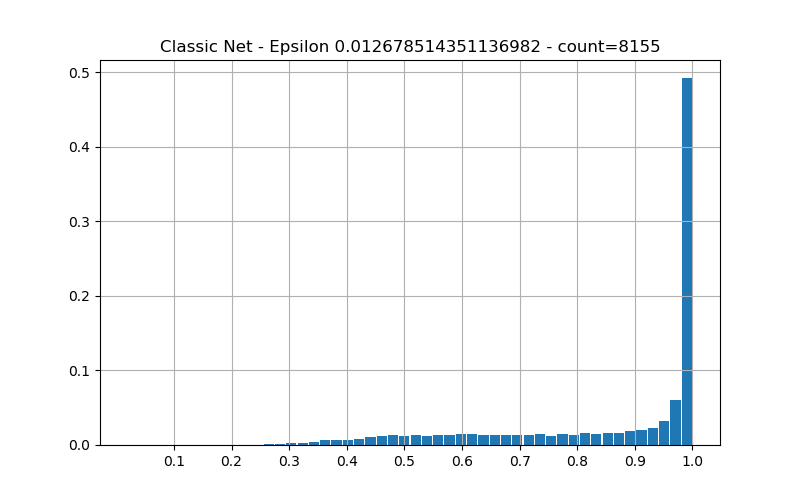

Statistical description of the predictions maximums
DescribeResult(nobs=8155, minmax=(0.24249267079507562114, 0.9998695921575567416), mean=0.85829484106202834544, variance=0.037305459492830536317, skewness=-1.2314895728697341528, kurtosis=0.19327037853233857648)

percentage of confident predictions (>=0.5): 0.914653586756591

Sample predictions
index 6015 prediction [0.   0.26 0.04 0.03 0.   0.06 0.   0.61 0.   0.  ]
index 3153 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6362 prediction [0.   0.01 0.87 0.   0.01 0.   0.12 0.   0.   0.  ]
index 3849 prediction [0.06 0.06 0.23 0.   0.02 0.01 0.06 0.57 0.   0.01]
index 2817 prediction [0.04 0.   0.14 0.08 0.   0.   0.12 0.   0.61 0.  ]


<IPython.core.display.Javascript object>


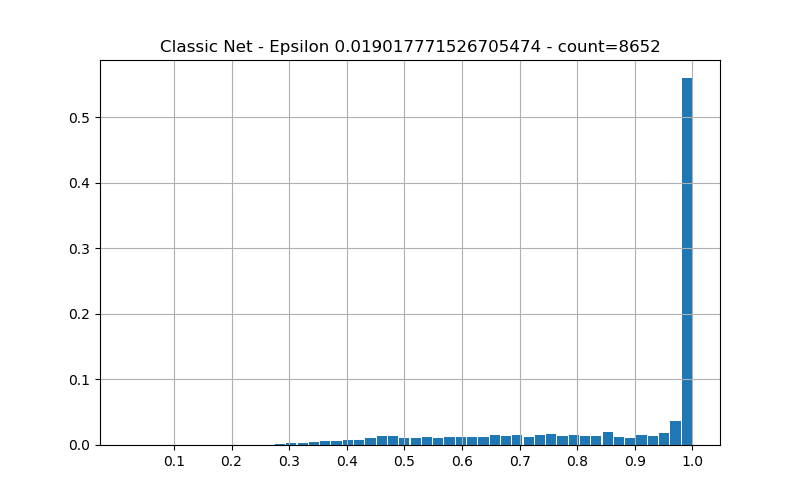

Statistical description of the predictions maximums
DescribeResult(nobs=8652, minmax=(0.21731295571664953039, 0.99964662393712951116), mean=0.86569245585906306263, variance=0.037149643709760831462, skewness=-1.2917755222598514169, kurtosis=0.36291645893974678661)

percentage of confident predictions (>=0.5): 0.9164355062413315

Sample predictions
index 136 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2196 prediction [0.   0.   0.   0.03 0.   0.   0.   0.   0.96 0.  ]
index 4703 prediction [0.   0.01 0.01 0.01 0.   0.73 0.   0.23 0.   0.  ]
index 5002 prediction [0.   0.52 0.16 0.02 0.   0.04 0.   0.25 0.   0.  ]
index 5975 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


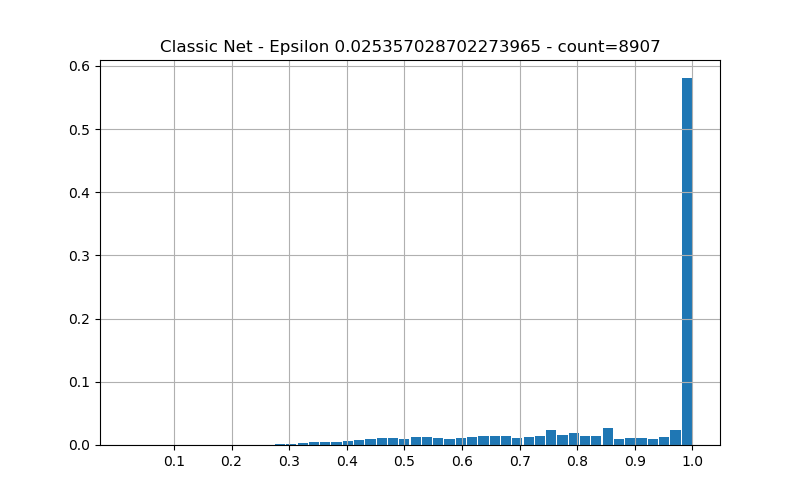

Statistical description of the predictions maximums
DescribeResult(nobs=8907, minmax=(0.25132038692496337827, 0.9997198654922907111), mean=0.8691122034916591823, variance=0.03579970033282588568, skewness=-1.3092127913471879643, kurtosis=0.47135683209134301465)

percentage of confident predictions (>=0.5): 0.9262377905018525

Sample predictions
index 2134 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7138 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3121 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7382 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 6452 prediction [0.01 0.   0.   0.   0.   0.   0.01 0.   0.98 0.  ]


<IPython.core.display.Javascript object>


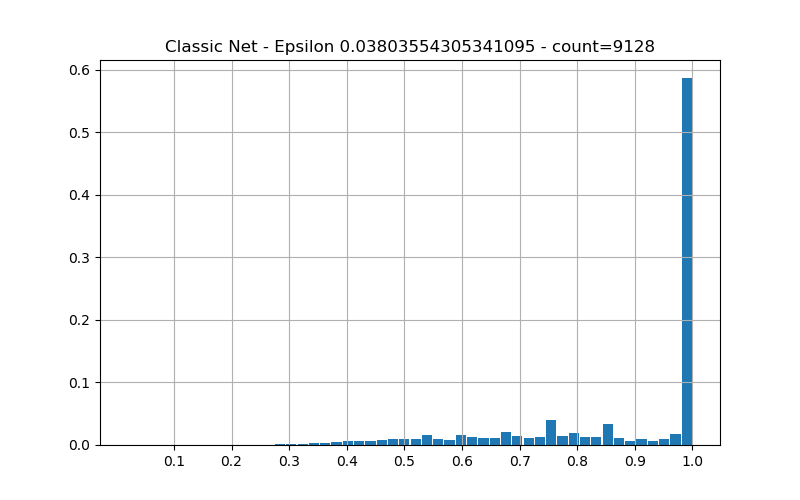

Statistical description of the predictions maximums
DescribeResult(nobs=9128, minmax=(0.23733733840724367933, 0.999864066861844704), mean=0.87350862808831041163, variance=0.032893762004831418852, skewness=-1.2958489810880132467, kurtosis=0.52211013181164575873)

percentage of confident predictions (>=0.5): 0.9409509202453987

Sample predictions
index 463 prediction [0.   0.19 0.05 0.05 0.   0.08 0.   0.63 0.   0.  ]
index 7892 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7023 prediction [0.   0.51 0.01 0.25 0.   0.01 0.   0.21 0.   0.  ]
index 9084 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3625 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


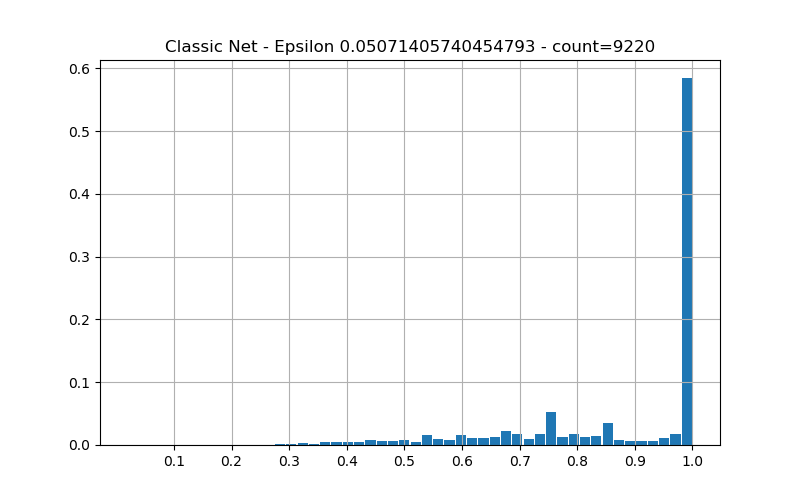

Statistical description of the predictions maximums
DescribeResult(nobs=9220, minmax=(0.20423852658170244198, 0.99978700686754652264), mean=0.8751721325760611319, variance=0.031633894289512289316, skewness=-1.3036178565895268217, kurtosis=0.6342085518121147649)

percentage of confident predictions (>=0.5): 0.9456616052060738

Sample predictions
index 9042 prediction [0.   0.03 0.02 0.03 0.   0.04 0.   0.86 0.   0.01]
index 3492 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 884 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8453 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 120 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]


<IPython.core.display.Javascript object>


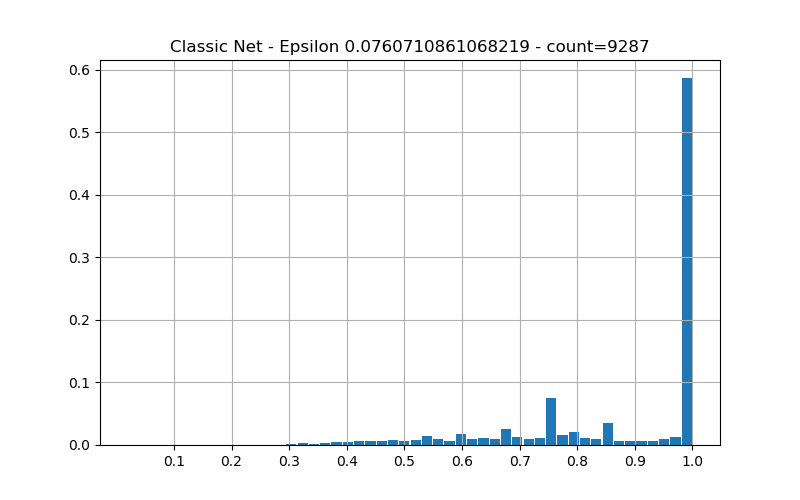

Statistical description of the predictions maximums
DescribeResult(nobs=9287, minmax=(0.23941577825030547194, 0.99986204618879229655), mean=0.8761891586387461696, variance=0.030770001275350056842, skewness=-1.3015493575014910401, kurtosis=0.6738192416258980582)

percentage of confident predictions (>=0.5): 0.9480994939162269

Sample predictions
index 3825 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6958 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1579 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7021 prediction [0.   0.02 0.07 0.07 0.   0.19 0.   0.65 0.   0.  ]
index 2852 prediction [0.   0.   0.   0.01 0.   0.   0.   0.   0.98 0.01]


<IPython.core.display.Javascript object>


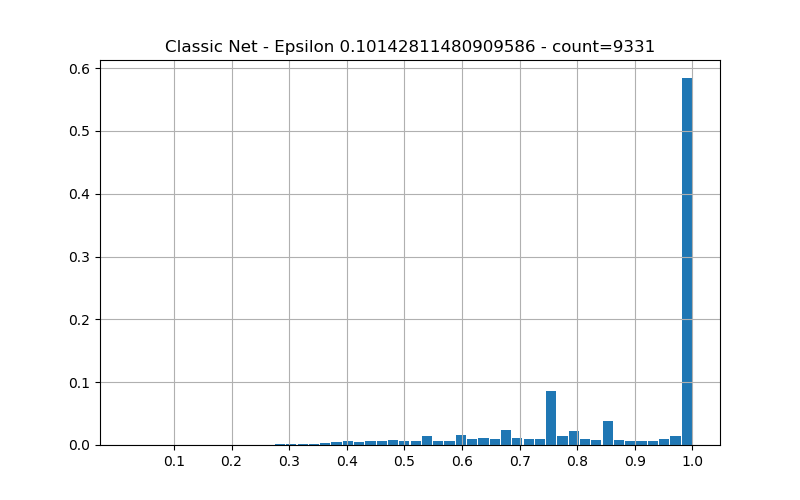

Statistical description of the predictions maximums
DescribeResult(nobs=9331, minmax=(0.23285234769619339133, 0.9998693790823576338), mean=0.8760536079746081331, variance=0.03062884125475245969, skewness=-1.3088962528850721505, kurtosis=0.7413389433083085048)

percentage of confident predictions (>=0.5): 0.9484513985639267

Sample predictions
index 6983 prediction [0.   0.07 0.05 0.09 0.   0.1  0.   0.68 0.   0.  ]
index 1282 prediction [0.   0.03 0.05 0.05 0.   0.2  0.   0.66 0.   0.  ]
index 2733 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 9083 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3706 prediction [0.   0.03 0.04 0.02 0.   0.01 0.   0.9  0.   0.01]


<IPython.core.display.Javascript object>


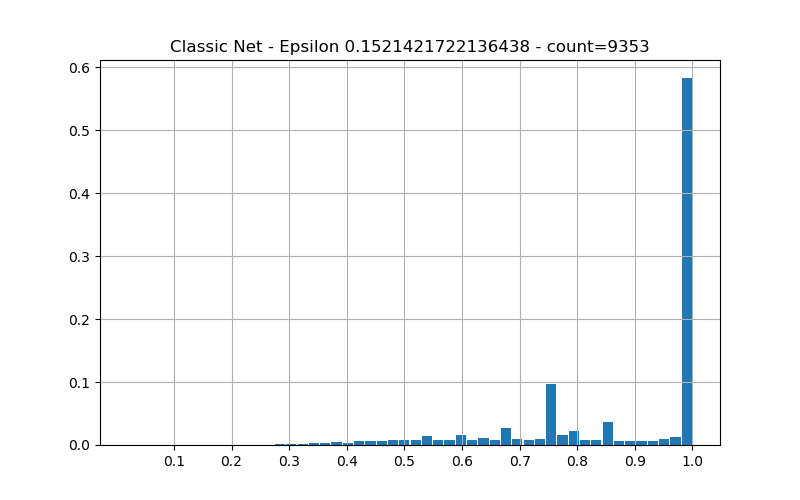

Statistical description of the predictions maximums
DescribeResult(nobs=9353, minmax=(0.22881291192168603975, 0.99986910002044453996), mean=0.8754057462204759025, variance=0.030437659957073240377, skewness=-1.2816577286548259146, kurtosis=0.6602741833141893288)

percentage of confident predictions (>=0.5): 0.9498556612851492

Sample predictions
index 4241 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 467 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5951 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 615 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7457 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


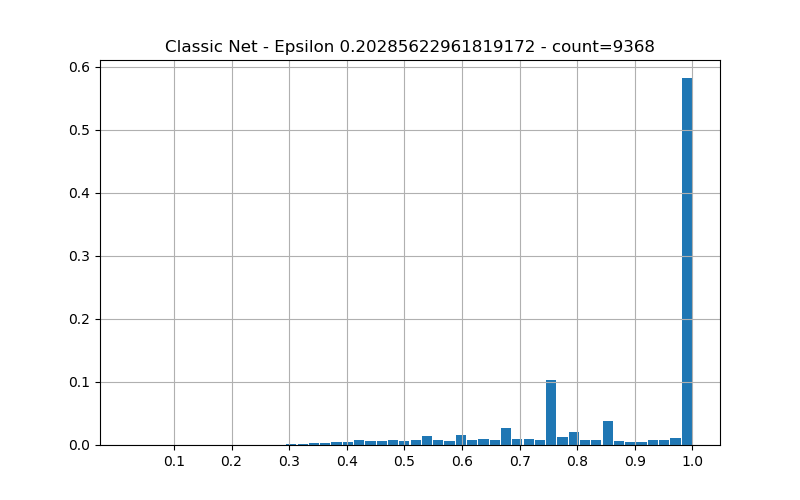

Statistical description of the predictions maximums
DescribeResult(nobs=9368, minmax=(0.2289234502197415188, 0.9998671897570238792), mean=0.874928271672779598, variance=0.030453787565911275914, skewness=-1.2698267975237244455, kurtosis=0.6152176036744802137)

percentage of confident predictions (>=0.5): 0.9480145175064048

Sample predictions
index 829 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 891 prediction [0.01 0.   0.   0.   0.01 0.01 0.   0.   0.96 0.01]
index 3426 prediction [0.   0.15 0.09 0.11 0.   0.05 0.   0.59 0.   0.  ]
index 6789 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 4540 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


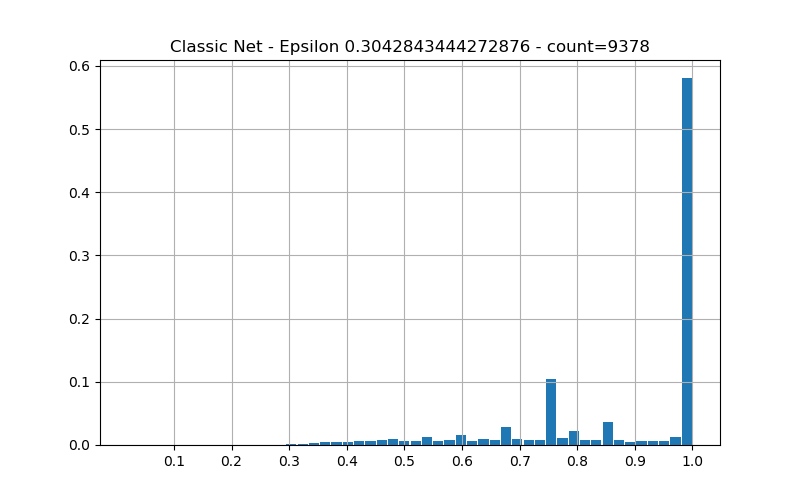

Statistical description of the predictions maximums
DescribeResult(nobs=9378, minmax=(0.21755384141966708116, 0.9998334751333095808), mean=0.8747396062632381004, variance=0.0304812307882826562, skewness=-1.2744994261140150533, kurtosis=0.6425337300145010386)

percentage of confident predictions (>=0.5): 0.9450842397099595

Sample predictions
index 597 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6001 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8948 prediction [0.   0.03 0.02 0.03 0.   0.04 0.   0.86 0.   0.01]
index 8464 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8860 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


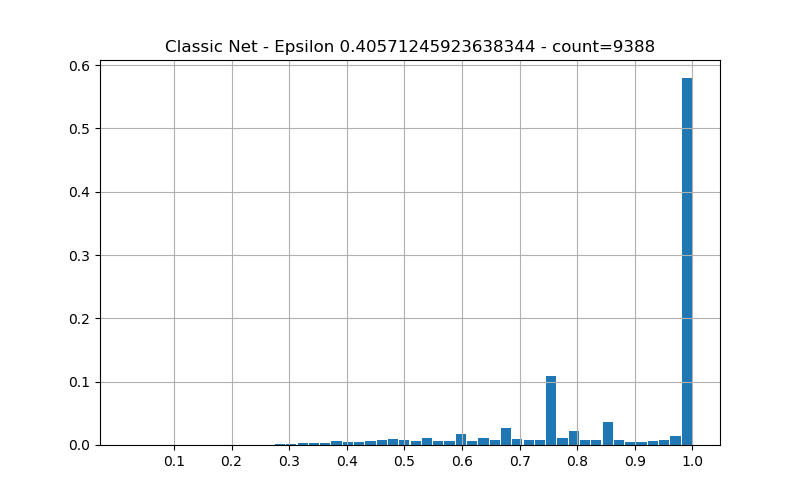

Statistical description of the predictions maximums
DescribeResult(nobs=9388, minmax=(0.21249488714585157852, 0.99976881799340025145), mean=0.8744941583173895994, variance=0.030556248227980345867, skewness=-1.2767347480856974058, kurtosis=0.6562986838968580374)

percentage of confident predictions (>=0.5): 0.9452492543672774

Sample predictions
index 2913 prediction [0.   0.07 0.02 0.06 0.   0.05 0.   0.8  0.   0.  ]
index 8142 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 9084 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7870 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8775 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


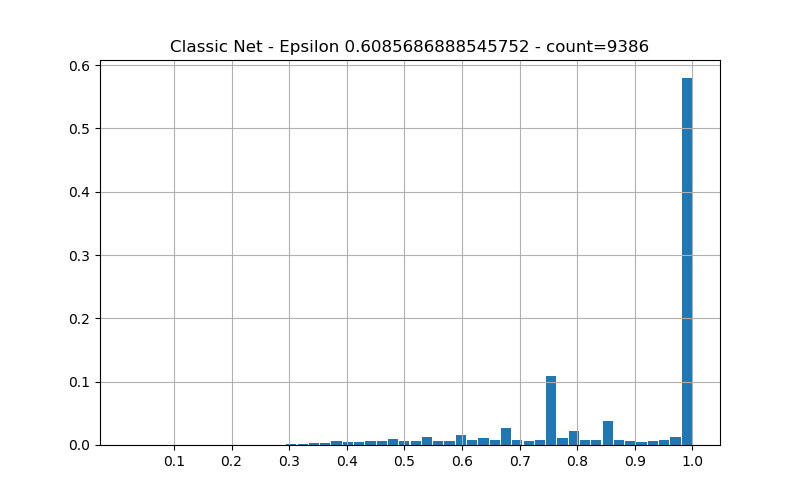

Statistical description of the predictions maximums
DescribeResult(nobs=9386, minmax=(0.24164231543589538353, 0.9997094881118508545), mean=0.87518520078785636, variance=0.03016737399874631231, skewness=-1.2779726800545345234, kurtosis=0.66814697161411013937)

percentage of confident predictions (>=0.5): 0.9473684210526315

Sample predictions
index 1353 prediction [0.   0.   0.   0.15 0.   0.   0.   0.01 0.   0.83]
index 1349 prediction [0.   0.08 0.1  0.05 0.   0.2  0.   0.56 0.   0.  ]
index 2693 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 5054 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6441 prediction [0.   0.   0.   0.01 0.   0.   0.03 0.   0.96 0.  ]


<IPython.core.display.Javascript object>


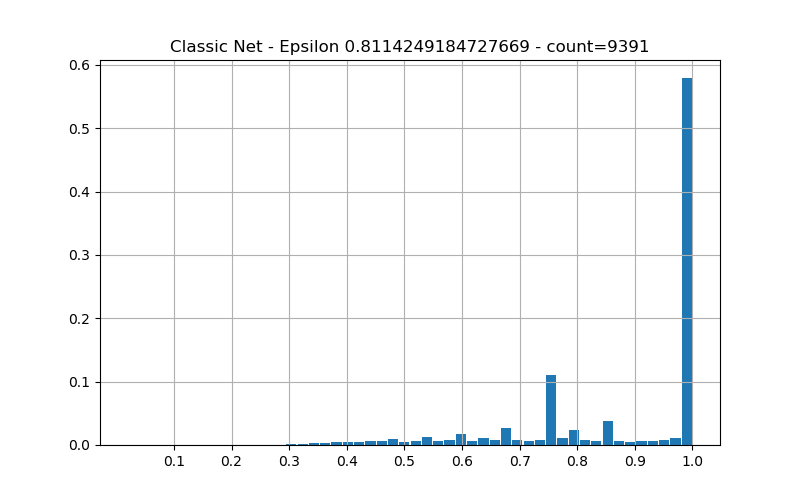

Statistical description of the predictions maximums
DescribeResult(nobs=9391, minmax=(0.24164231543589538353, 0.9995791190431218337), mean=0.8755025194369723707, variance=0.029942171708647127921, skewness=-1.2753198195267631225, kurtosis=0.66288126332516283446)

percentage of confident predictions (>=0.5): 0.9479288680651687

Sample predictions
index 3866 prediction [0.   0.07 0.02 0.06 0.   0.05 0.   0.8  0.   0.  ]
index 3557 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 5185 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 9254 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5739 prediction [0.   0.2  0.41 0.01 0.   0.01 0.01 0.35 0.   0.  ]


<IPython.core.display.Javascript object>


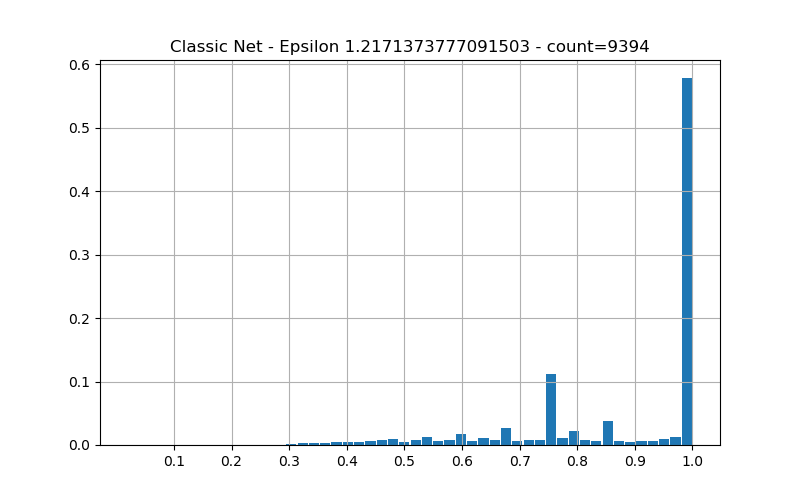

Statistical description of the predictions maximums
DescribeResult(nobs=9394, minmax=(0.24164231543589538353, 0.99951060586625461177), mean=0.8756789386607678885, variance=0.029759381891729409277, skewness=-1.2683176709857015051, kurtosis=0.6403848030224007183)

percentage of confident predictions (>=0.5): 0.9487971045348095

Sample predictions
index 6539 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 513 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8077 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5575 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 6590 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


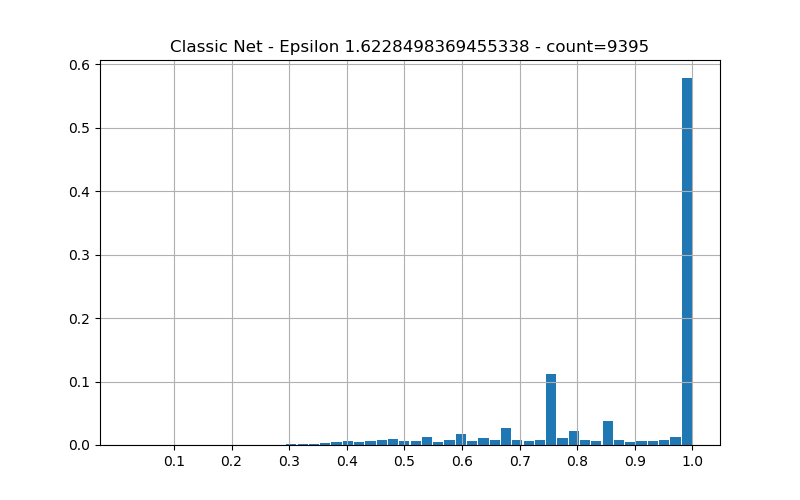

Statistical description of the predictions maximums
DescribeResult(nobs=9395, minmax=(0.24164231543589538353, 0.99951060586625461177), mean=0.87569776945162655705, variance=0.029647767828858584504, skewness=-1.259650894920449691, kurtosis=0.6055994604933808904)

percentage of confident predictions (>=0.5): 0.9493347525279404

Sample predictions
index 5921 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2054 prediction [0.   0.07 0.05 0.09 0.   0.1  0.   0.68 0.   0.  ]
index 3321 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2535 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6990 prediction [0.   0.   0.   0.02 0.   0.   0.   0.   0.97 0.01]


<IPython.core.display.Javascript object>


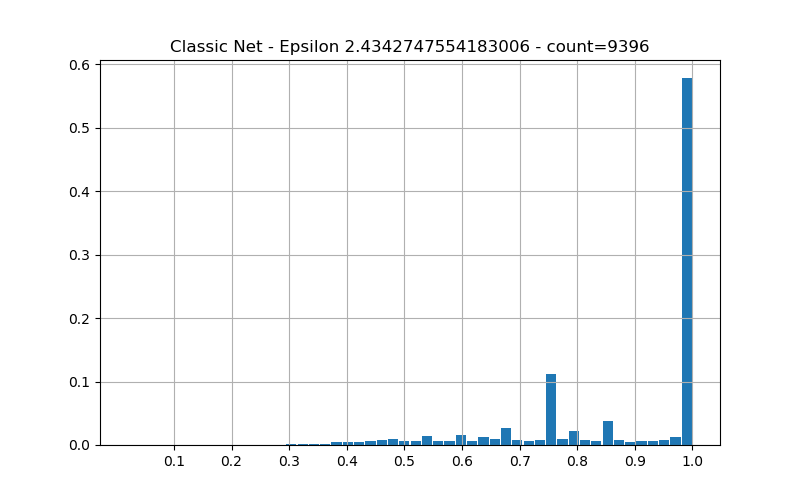

Statistical description of the predictions maximums
DescribeResult(nobs=9396, minmax=(0.22862905498086426045, 0.99951060586625461177), mean=0.87577724683622031255, variance=0.02961528670056206285, skewness=-1.2629976001429896695, kurtosis=0.627546361218882592)

percentage of confident predictions (>=0.5): 0.9494465730097914

Sample predictions
index 7843 prediction [0.   0.   0.   0.12 0.34 0.   0.   0.53 0.   0.  ]
index 1501 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3966 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 834 prediction [0.   0.   0.   0.01 0.   0.   0.   0.   0.99 0.  ]
index 1298 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


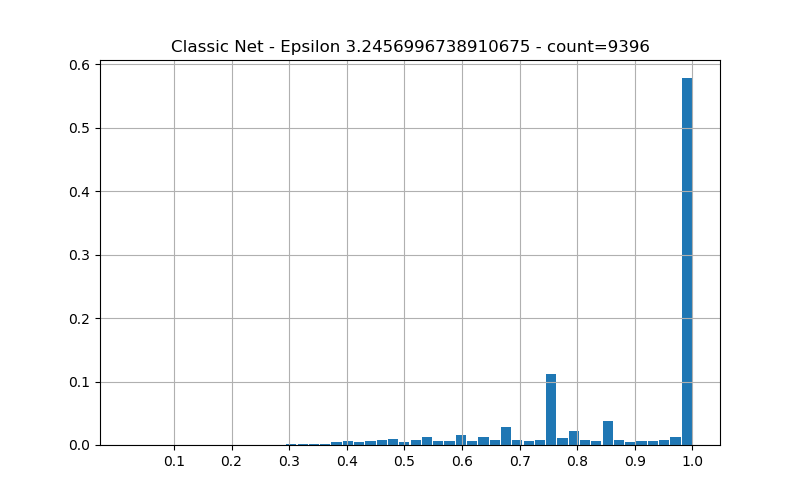

Statistical description of the predictions maximums
DescribeResult(nobs=9396, minmax=(0.22862317878013393515, 0.99951060586625461177), mean=0.87582595823782413203, variance=0.029560198885553097218, skewness=-1.2611109729514689959, kurtosis=0.62171750026024944543)

percentage of confident predictions (>=0.5): 0.9499787143465305

Sample predictions
index 204 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4252 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3602 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8042 prediction [0.02 0.   0.   0.   0.   0.02 0.08 0.   0.88 0.  ]
index 2585 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


In [32]:
# rerun the classic model on adv examples
for i ,classic_raw_images in enumerate(classic_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(classic_raw_images))
    t = 'Classic Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(classic_model, dl, title=t, verbose=True)

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/plot_pred_histogram.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)


<IPython.core.display.Javascript object>


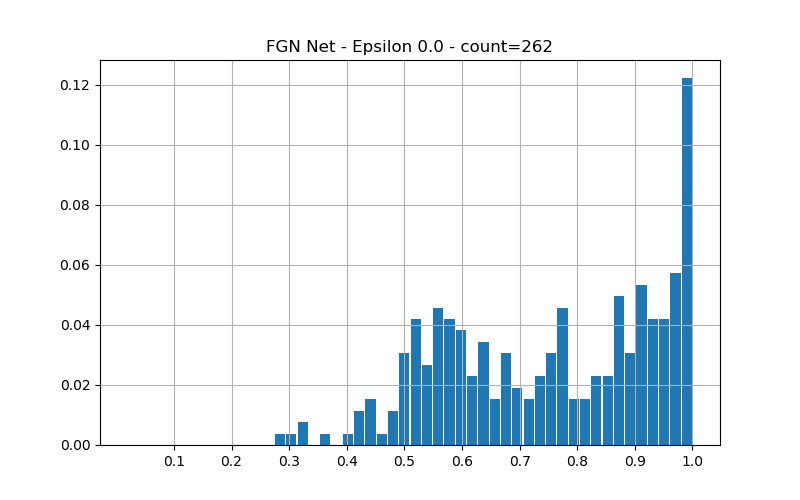

Statistical description of the predictions maximums
DescribeResult(nobs=262, minmax=(0.29119873955305365965, 0.999555832295226862), mean=0.75594666311529608657, variance=0.034891558733431566755, skewness=-0.31839235976788609996, kurtosis=-1.0829188955978131338)

percentage of confident predictions (>=0.5): 0.9198473282442748

Sample predictions
index 74 prediction [0.   0.   0.   0.   0.22 0.   0.   0.   0.   0.77]
index 170 prediction [0.   0.01 0.04 0.01 0.   0.04 0.9  0.   0.   0.  ]
index 6 prediction [0.   0.   0.04 0.17 0.   0.   0.   0.76 0.03 0.  ]
index 179 prediction [0.   0.   0.   0.   0.   0.   0.   0.08 0.   0.91]
index 1 prediction [0.   0.05 0.   0.   0.   0.   0.   0.91 0.   0.04]


<IPython.core.display.Javascript object>


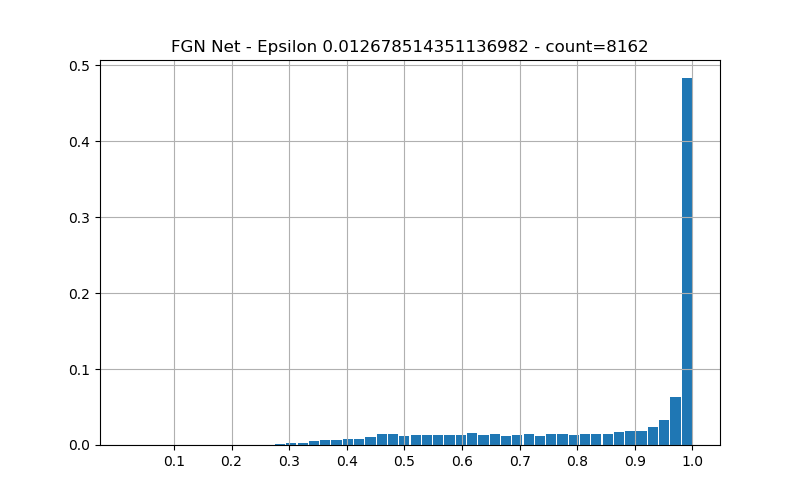

Statistical description of the predictions maximums
DescribeResult(nobs=8162, minmax=(0.24089651721136315777, 0.99972767584345137323), mean=0.85478563224185386313, variance=0.03821920928494500598, skewness=-1.2013521370064970358, kurtosis=0.098316088732794021474)

percentage of confident predictions (>=0.5): 0.9110512129380054

Sample predictions
index 2582 prediction [0.04 0.   0.   0.   0.   0.02 0.04 0.   0.9  0.  ]
index 2725 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3425 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7903 prediction [0.   0.   0.   0.   0.   0.02 0.07 0.   0.91 0.  ]
index 7680 prediction [0.   0.   0.   0.02 0.   0.   0.   0.   0.98 0.  ]


<IPython.core.display.Javascript object>


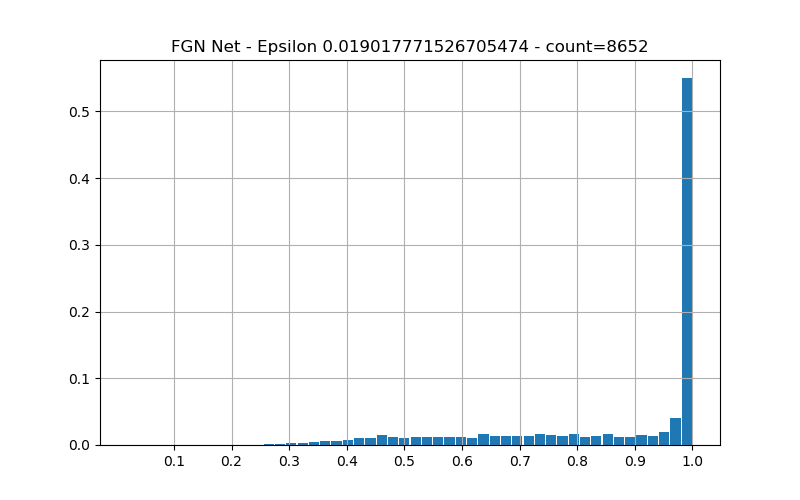

Statistical description of the predictions maximums
DescribeResult(nobs=8652, minmax=(0.21784634472616231216, 0.9997075094541503225), mean=0.861985577473280684, variance=0.03805268793042121008, skewness=-1.2567378613193979177, kurtosis=0.25864605758861667706)

percentage of confident predictions (>=0.5): 0.9134304207119741

Sample predictions
index 2336 prediction [0.   0.01 0.   0.92 0.   0.06 0.   0.   0.   0.01]
index 6127 prediction [0.   0.01 0.01 0.06 0.   0.14 0.   0.77 0.   0.  ]
index 6858 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2716 prediction [0.   0.01 0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 1849 prediction [0.   0.02 0.   0.   0.   0.   0.   0.   0.96 0.01]


<IPython.core.display.Javascript object>


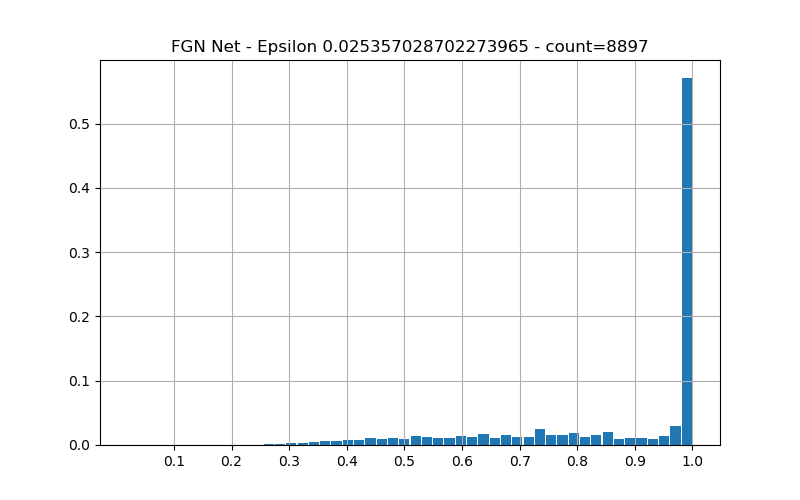

Statistical description of the predictions maximums
DescribeResult(nobs=8897, minmax=(0.23814343655302359914, 0.99964351506792335273), mean=0.8646786142612455123, variance=0.036935002257086239478, skewness=-1.2663570332189812833, kurtosis=0.34226291666185164005)

percentage of confident predictions (>=0.5): 0.9219961784871304

Sample predictions
index 5780 prediction [0.   0.   0.   0.01 0.   0.   0.   0.   0.98 0.  ]
index 3709 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4658 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 897 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5155 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


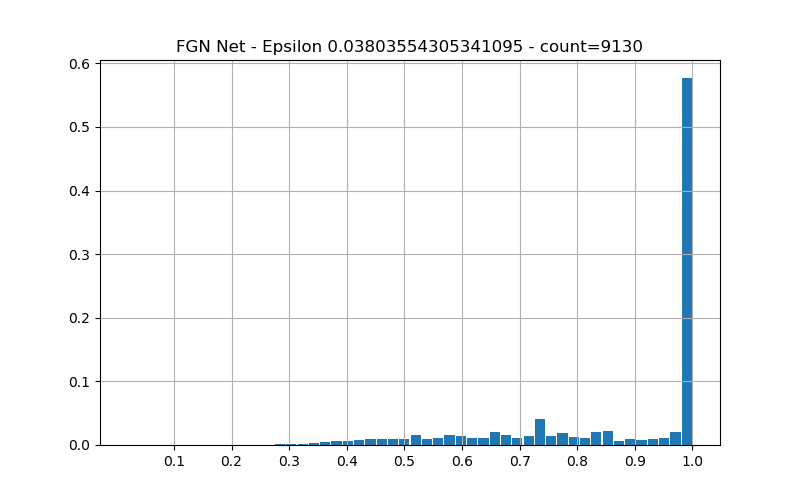

Statistical description of the predictions maximums
DescribeResult(nobs=9130, minmax=(0.22865069888462278624, 0.999786641850020386), mean=0.86539925568676915793, variance=0.03495785014368274572, skewness=-1.2074018709054510427, kurtosis=0.2252805086902690138)

percentage of confident predictions (>=0.5): 0.9346111719605695

Sample predictions
index 2257 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 2843 prediction [0.   0.03 0.05 0.08 0.   0.69 0.   0.15 0.   0.  ]
index 4947 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1993 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8426 prediction [0.   0.04 0.34 0.   0.   0.47 0.1  0.04 0.   0.  ]


<IPython.core.display.Javascript object>


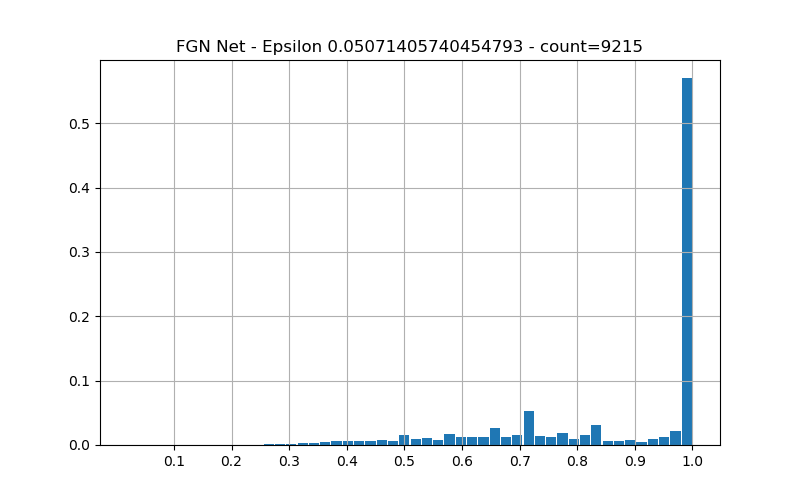

Statistical description of the predictions maximums
DescribeResult(nobs=9215, minmax=(0.22337020636625008628, 0.99978654374736894184), mean=0.86274373397131442175, variance=0.034782674655157947005, skewness=-1.1736445244889910076, kurtosis=0.19240653999426999199)

percentage of confident predictions (>=0.5): 0.9405317417254476

Sample predictions
index 1739 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 6242 prediction [0.   0.04 0.03 0.06 0.   0.05 0.   0.82 0.   0.  ]
index 2050 prediction [0.   0.07 0.06 0.1  0.   0.11 0.   0.65 0.   0.  ]
index 4622 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 5451 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


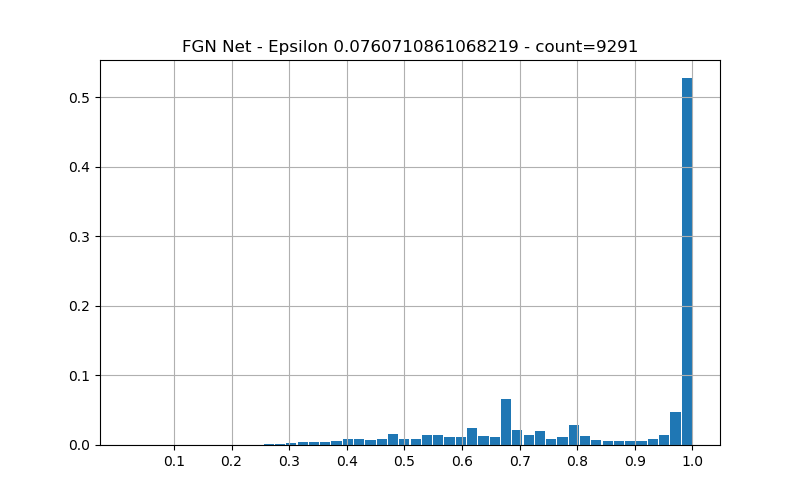

Statistical description of the predictions maximums
DescribeResult(nobs=9291, minmax=(0.18280088540708361016, 0.9994020085913846339), mean=0.84766338611903400046, variance=0.037441265036784848505, skewness=-1.0366893760227400465, kurtosis=-0.18958045338657825499)

percentage of confident predictions (>=0.5): 0.9248735335270692

Sample predictions
index 85 prediction [0.   0.12 0.09 0.12 0.   0.11 0.   0.57 0.   0.  ]
index 4382 prediction [0.   0.47 0.06 0.4  0.   0.06 0.   0.02 0.   0.  ]
index 543 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 1150 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 2987 prediction [0.   0.   0.   0.   0.   0.01 0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


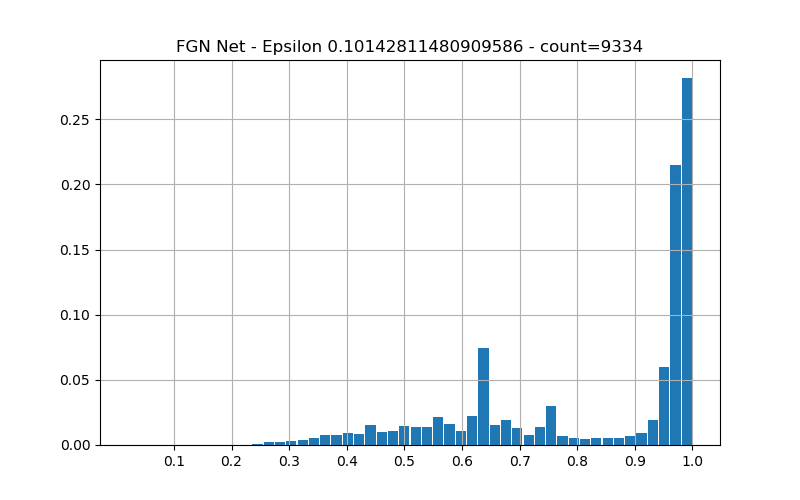

Statistical description of the predictions maximums
DescribeResult(nobs=9334, minmax=(0.2079422438473148601, 0.99833771192181156864), mean=0.8199928594623064736, variance=0.041266957463138977973, skewness=-0.87644748065758902036, kurtosis=-0.60847755402972519465)

percentage of confident predictions (>=0.5): 0.9074351832011999

Sample predictions
index 5195 prediction [0.   0.01 0.   0.01 0.   0.   0.   0.   0.96 0.01]
index 7095 prediction [0.   0.   0.   0.01 0.   0.   0.   0.   0.99 0.  ]
index 1803 prediction [0.   0.   0.   0.01 0.   0.01 0.   0.   0.96 0.01]
index 9010 prediction [0.   0.   0.   0.02 0.   0.01 0.   0.   0.94 0.01]
index 5855 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


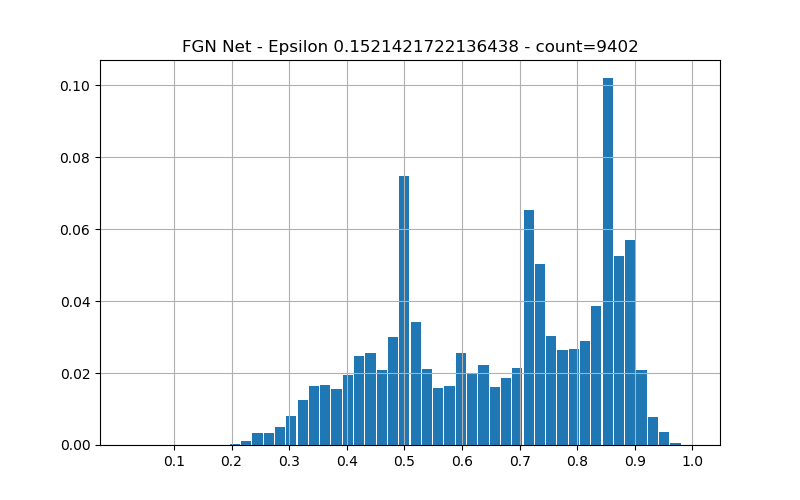

Statistical description of the predictions maximums
DescribeResult(nobs=9402, minmax=(0.17568615710485914325, 0.9893147633637632934), mean=0.66375414625480720057, variance=0.032857275485156428255, skewness=-0.3500700293030225727, kurtosis=-1.101231204978911728)

percentage of confident predictions (>=0.5): 0.7694107636673049

Sample predictions
index 6105 prediction [0.   0.01 0.02 0.05 0.   0.03 0.   0.01 0.85 0.02]
index 1780 prediction [0.   0.01 0.02 0.1  0.   0.1  0.   0.01 0.72 0.03]
index 6447 prediction [0.   0.01 0.01 0.1  0.   0.12 0.   0.01 0.69 0.07]
index 923 prediction [0.   0.1  0.09 0.2  0.   0.24 0.01 0.35 0.   0.01]
index 732 prediction [0.   0.01 0.02 0.1  0.   0.1  0.   0.01 0.72 0.03]


<IPython.core.display.Javascript object>


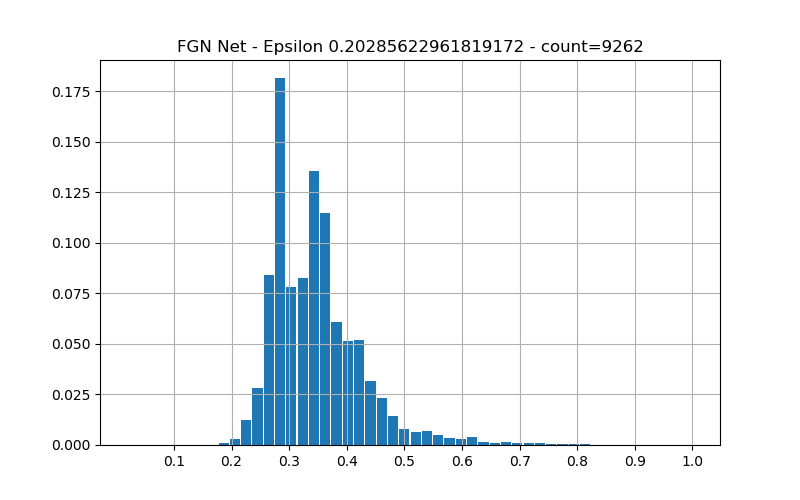

Statistical description of the predictions maximums
DescribeResult(nobs=9262, minmax=(0.17208985743552315041, 0.95013535898139500884), mean=0.34599492000664491248, variance=0.0061830712899355325906, skewness=1.5571064718851183351, kurtosis=4.3975019606279668904)

percentage of confident predictions (>=0.5): 0.04135175987907579

Sample predictions
index 5961 prediction [0.   0.1  0.14 0.16 0.02 0.19 0.01 0.36 0.   0.03]
index 5231 prediction [0.   0.13 0.11 0.18 0.01 0.16 0.01 0.36 0.   0.03]
index 5532 prediction [0.01 0.05 0.08 0.27 0.01 0.2  0.01 0.08 0.24 0.05]
index 3887 prediction [0.   0.14 0.11 0.17 0.01 0.16 0.01 0.36 0.   0.03]
index 5349 prediction [0.01 0.04 0.08 0.24 0.01 0.15 0.01 0.06 0.34 0.07]


<IPython.core.display.Javascript object>


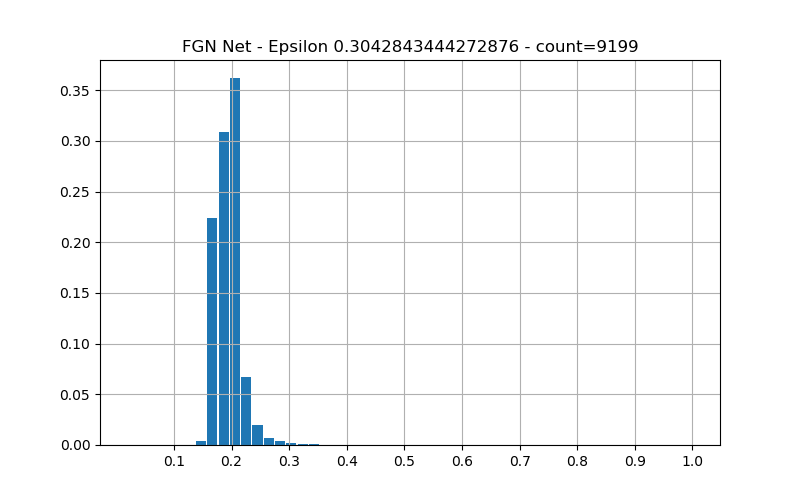

Statistical description of the predictions maximums
DescribeResult(nobs=9199, minmax=(0.14594676405506140028, 0.4868537019494196326), mean=0.19455757592056886929, variance=0.00045499663815564029575, skewness=2.0240795681729955528, kurtosis=12.624001492518652781)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6774 prediction [0.02 0.12 0.14 0.17 0.06 0.17 0.06 0.15 0.04 0.06]
index 4511 prediction [0.02 0.1  0.13 0.2  0.05 0.16 0.04 0.12 0.1  0.07]
index 946 prediction [0.03 0.1  0.13 0.19 0.05 0.16 0.04 0.12 0.1  0.07]
index 8678 prediction [0.02 0.09 0.13 0.2  0.05 0.16 0.04 0.13 0.1  0.07]
index 3463 prediction [0.02 0.11 0.11 0.19 0.06 0.2  0.04 0.11 0.09 0.08]


<IPython.core.display.Javascript object>


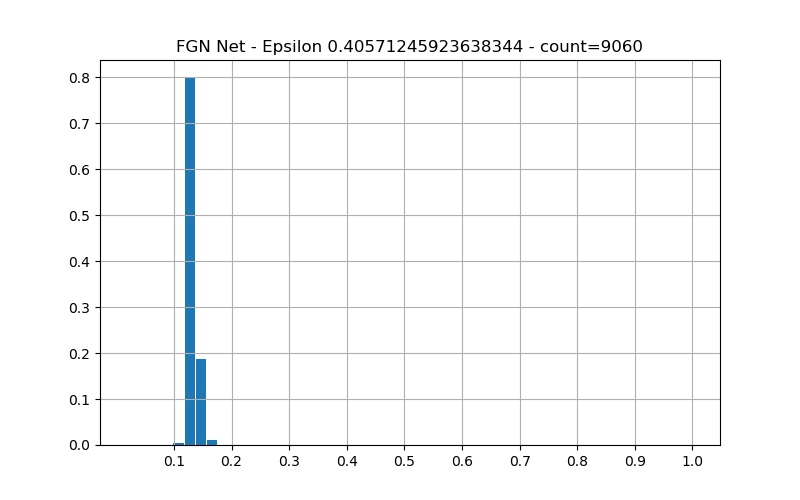

Statistical description of the predictions maximums
DescribeResult(nobs=9060, minmax=(0.112865993145803793675, 0.20465716420142972865), mean=0.13298679914900669, variance=5.1471689696916658415e-05, skewness=1.6855363792412458521, kurtosis=6.681997280908048938)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8358 prediction [0.06 0.11 0.12 0.13 0.09 0.13 0.1  0.09 0.1  0.08]
index 2358 prediction [0.05 0.11 0.12 0.13 0.08 0.13 0.09 0.1  0.1  0.08]
index 3619 prediction [0.05 0.11 0.12 0.13 0.09 0.13 0.09 0.1  0.1  0.08]
index 4151 prediction [0.05 0.11 0.12 0.14 0.08 0.13 0.09 0.1  0.1  0.08]
index 2804 prediction [0.05 0.11 0.12 0.14 0.08 0.13 0.09 0.1  0.1  0.08]


<IPython.core.display.Javascript object>


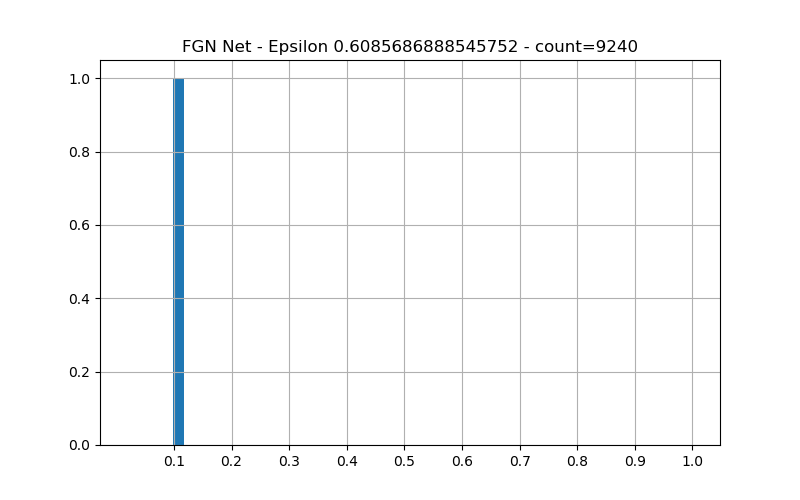

Statistical description of the predictions maximums
DescribeResult(nobs=9240, minmax=(0.10071369721791573345, 0.1127422085437045402), mean=0.10334196814452099589, variance=1.4653507420994848445e-06, skewness=2.1491122827088289529, kurtosis=7.8069546936655227565)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7252 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]
index 7332 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]
index 1111 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.1  0.09]
index 5321 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]
index 3676 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]


<IPython.core.display.Javascript object>


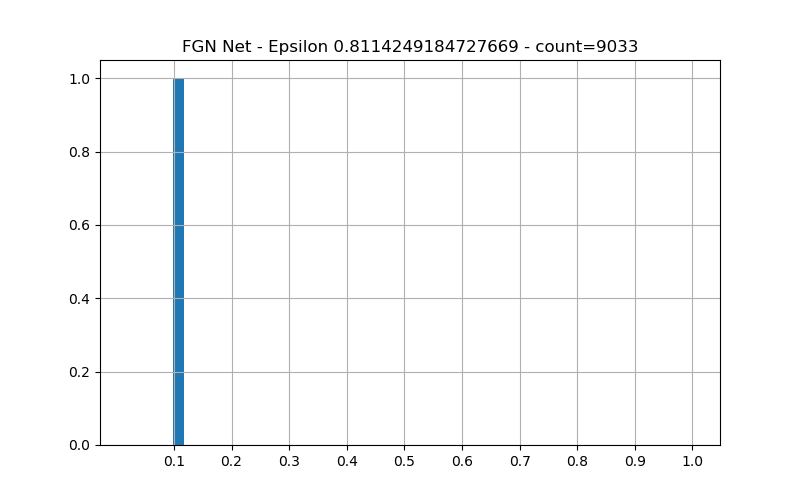

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10001334134045606415, 0.10193598160300048794), mean=0.100258154597255417096, variance=2.986710464602333485e-08, skewness=3.032229527333082561, kurtosis=14.593702042494161964)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 1458 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4877 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2996 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4552 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5273 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


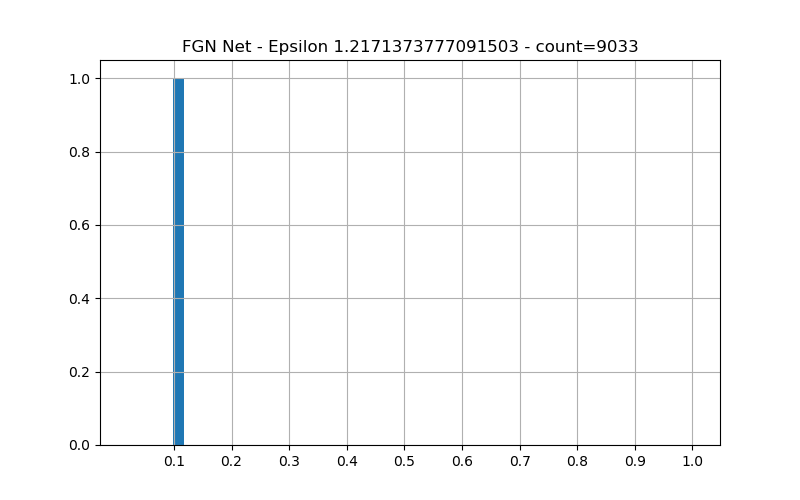

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000000014158719051, 0.10001260357681996033), mean=0.10000020137894502003, variance=3.095096719032651455e-13, skewness=9.992823735208726441, kurtosis=141.96670343090011059)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 218 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3497 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7751 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6987 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1623 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


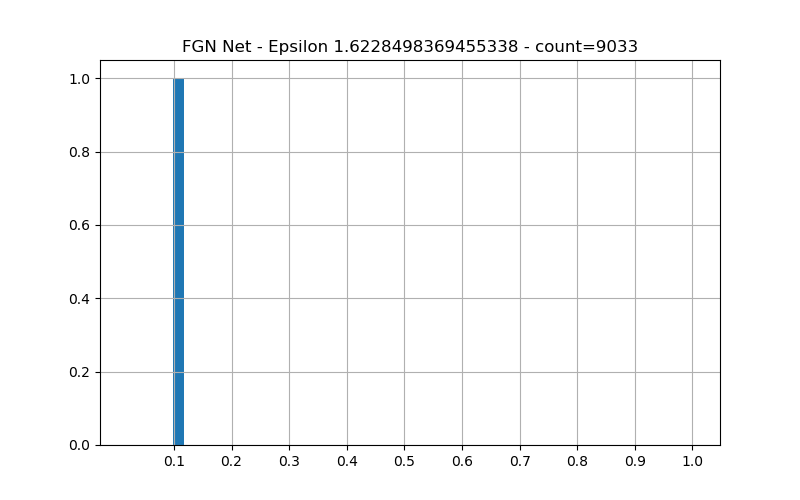

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000000000000001537, 0.10000000969048526289), mean=0.10000000002863757577, variance=6.7071205206344531543e-20, skewness=22.063853200889071121, kurtosis=638.2146981375858377)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7033 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2090 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4154 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2792 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8911 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


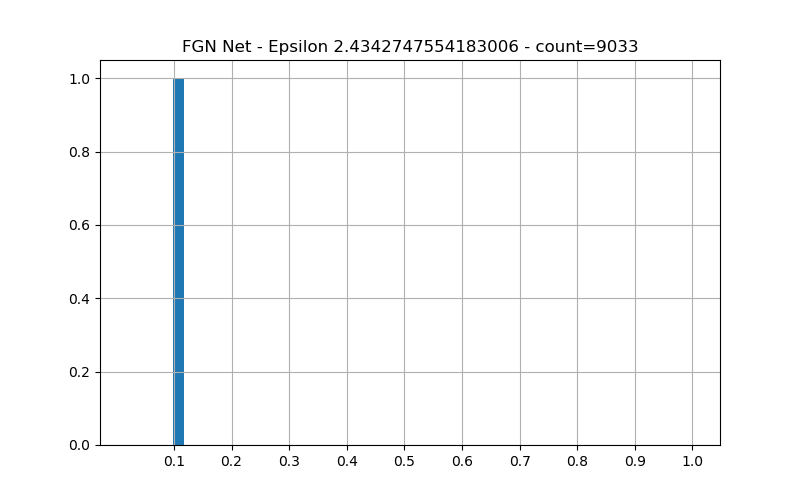

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.100000000000000012246), mean=0.10000000000000000002, variance=4.6175298247029476172e-38, skewness=47.405204355039168553, kurtosis=2490.1711925804264194)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8369 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3569 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 573 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2984 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7922 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


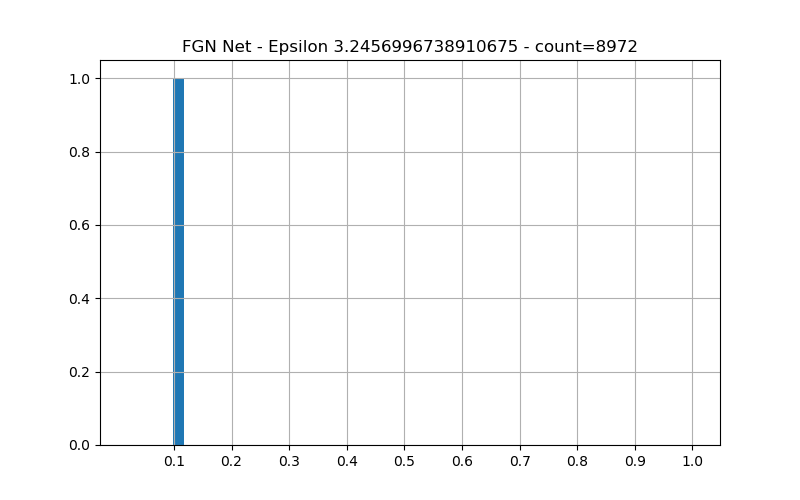

Statistical description of the predictions maximums
DescribeResult(nobs=8972, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.836914661753421358e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4076 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6755 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1749 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7343 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1112 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [33]:
# rerun the fgn model on adv examples
for i ,fgn_raw_images in enumerate(fgn_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(fgn_raw_images))
    t = 'FGN Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(fgn_model, dl, title=t, verbose=True)

<IPython.core.display.Javascript object>


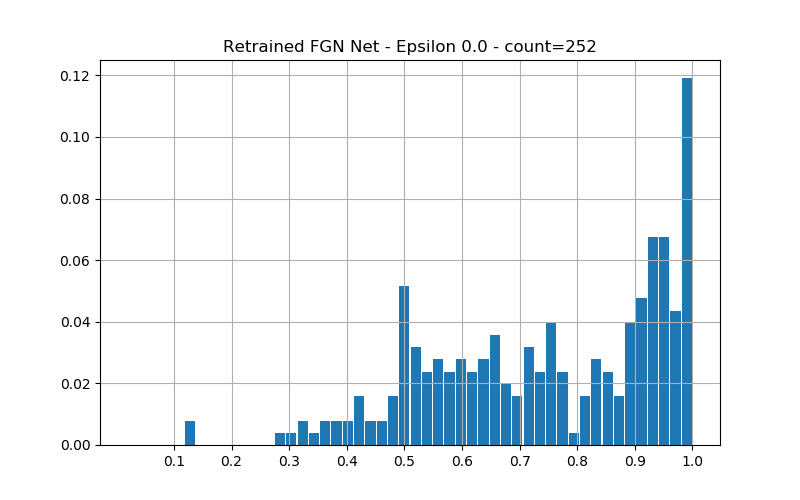

Statistical description of the predictions maximums
DescribeResult(nobs=252, minmax=(0.12838793336085239952, 0.99968229866298220364), mean=0.74737635153030614835, variance=0.040912618364030457385, skewness=-0.5000287726272786468, kurtosis=-0.68835764904694216526)

percentage of confident predictions (>=0.5): 0.876984126984127

Sample predictions
index 159 prediction [0.01 0.   0.   0.   0.   0.07 0.   0.   0.91 0.  ]
index 89 prediction [0.   0.   0.   0.   0.   0.01 0.   0.   0.98 0.  ]
index 147 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 193 prediction [0.   0.01 0.11 0.88 0.   0.   0.   0.   0.   0.  ]
index 208 prediction [0.   0.   0.   0.67 0.   0.01 0.   0.01 0.25 0.07]


<IPython.core.display.Javascript object>


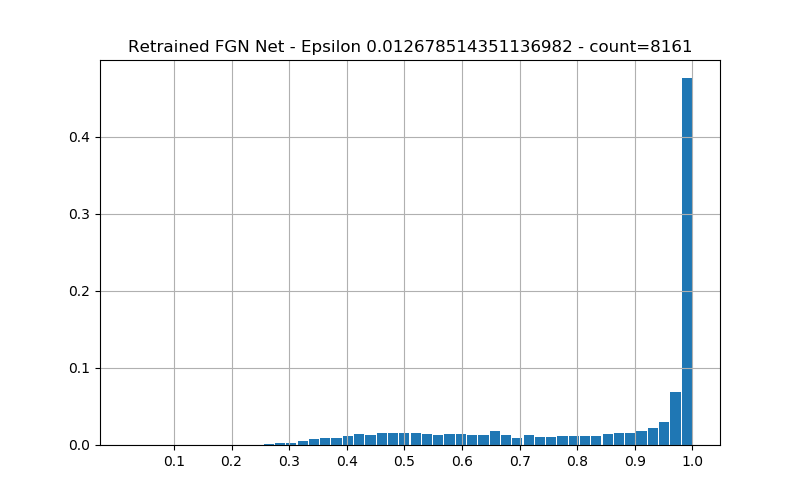

Statistical description of the predictions maximums
DescribeResult(nobs=8161, minmax=(0.1274002622910436212, 0.9993105957953032649), mean=0.84206416270369748353, variance=0.043579801119149309954, skewness=-1.1014905027688860289, kurtosis=-0.23240397102717725198)

percentage of confident predictions (>=0.5): 0.8857983090307561

Sample predictions
index 392 prediction [0.   0.03 0.03 0.03 0.   0.04 0.   0.86 0.   0.01]
index 1000 prediction [0.02 0.   0.   0.03 0.03 0.04 0.04 0.   0.81 0.02]
index 2266 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 796 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1844 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


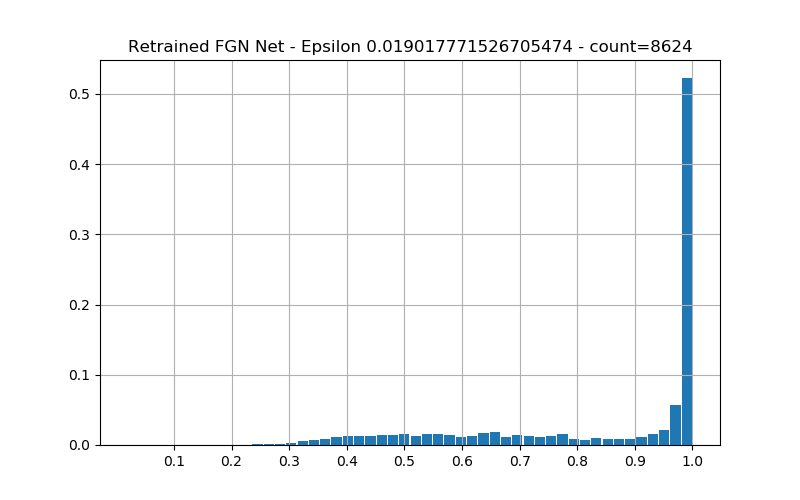

Statistical description of the predictions maximums
DescribeResult(nobs=8624, minmax=(0.1266087151482954498, 0.99929797885194633704), mean=0.84141256409118080637, variance=0.045264076668191926234, skewness=-1.0732796743071677416, kurtosis=-0.31875092891897486127)

percentage of confident predictions (>=0.5): 0.8834647495361782

Sample predictions
index 8485 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 6377 prediction [0.   0.   0.   0.01 0.   0.   0.   0.   0.99 0.  ]
index 1859 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.01]
index 8623 prediction [0.   0.06 0.1  0.05 0.   0.13 0.   0.66 0.   0.  ]
index 4389 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


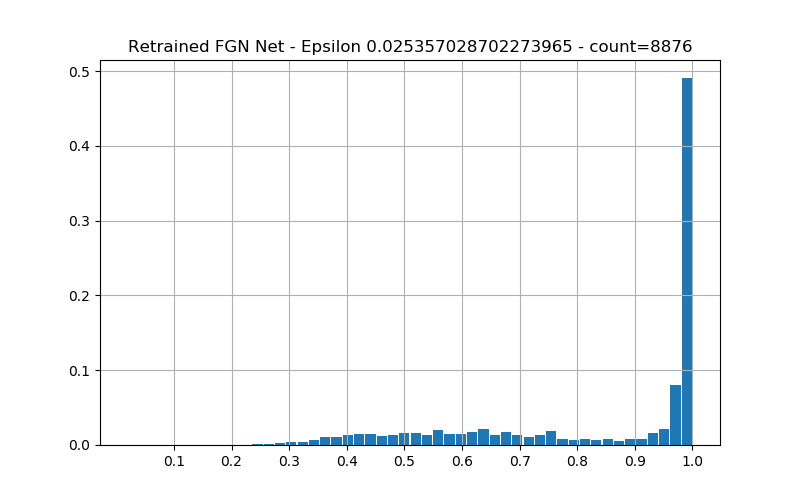

Statistical description of the predictions maximums
DescribeResult(nobs=8876, minmax=(0.1256248937817177639, 0.99841598748412016155), mean=0.8331414667670005073, variance=0.046431491702845228007, skewness=-0.99738152921498562074, kurtosis=-0.4869679750760142567)

percentage of confident predictions (>=0.5): 0.8797881928796756

Sample predictions
index 5924 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2894 prediction [0.   0.11 0.59 0.08 0.   0.2  0.   0.02 0.   0.  ]
index 4088 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5364 prediction [0.   0.04 0.09 0.08 0.   0.13 0.   0.64 0.   0.01]
index 3240 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


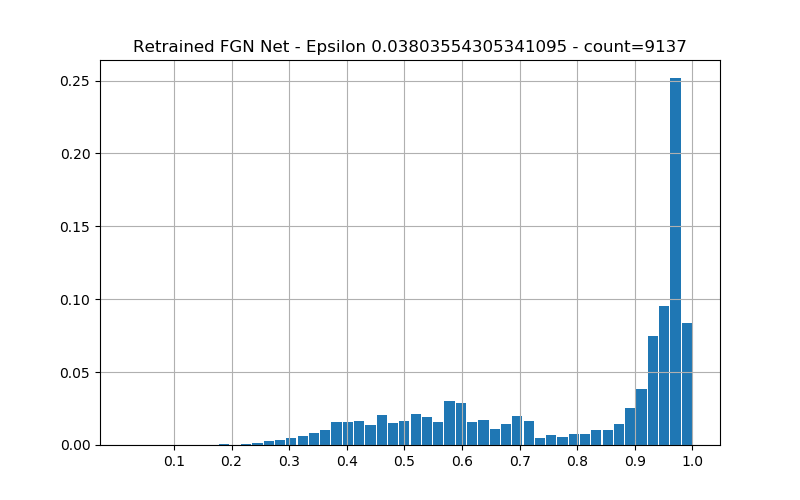

Statistical description of the predictions maximums
DescribeResult(nobs=9137, minmax=(0.123348055688971018616, 0.9964811355021450161), mean=0.79213881925963677155, variance=0.046853611593485101818, skewness=-0.7985040810508916108, kurtosis=-0.85058390643840069167)

percentage of confident predictions (>=0.5): 0.8557513407026376

Sample predictions
index 6698 prediction [0.   0.   0.   0.01 0.   0.01 0.   0.   0.98 0.  ]
index 802 prediction [0.   0.06 0.11 0.1  0.   0.22 0.   0.51 0.   0.  ]
index 2601 prediction [0.03 0.09 0.   0.07 0.04 0.04 0.59 0.   0.13 0.  ]
index 5785 prediction [0.   0.04 0.01 0.04 0.   0.   0.   0.91 0.   0.  ]
index 1296 prediction [0.   0.08 0.07 0.07 0.   0.08 0.   0.68 0.   0.01]


<IPython.core.display.Javascript object>


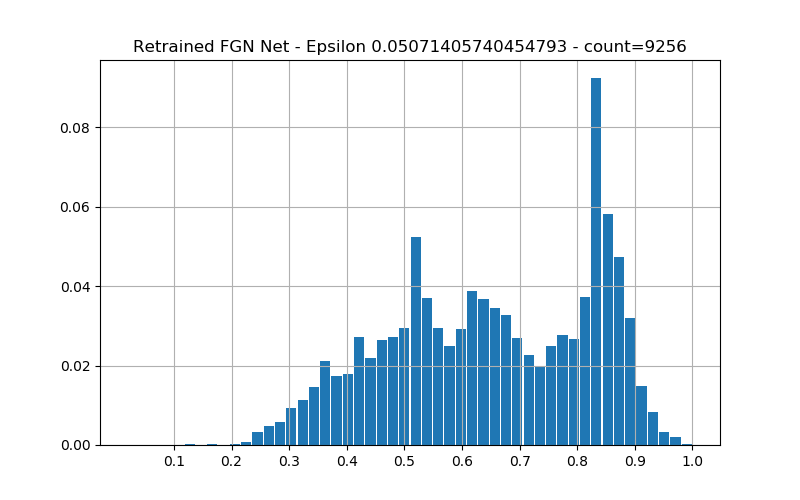

Statistical description of the predictions maximums
DescribeResult(nobs=9256, minmax=(0.12068280133382061304, 0.9930483603617268531), mean=0.65054179778577476734, variance=0.031323773498619865445, skewness=-0.25836114202601766956, kurtosis=-1.0315915101257844495)

percentage of confident predictions (>=0.5): 0.7751728608470182

Sample predictions
index 3075 prediction [0.   0.16 0.15 0.24 0.   0.21 0.   0.22 0.   0.  ]
index 6171 prediction [0.   0.08 0.08 0.2  0.   0.23 0.   0.39 0.   0.01]
index 8039 prediction [0.   0.1  0.1  0.17 0.   0.15 0.   0.47 0.   0.01]
index 7770 prediction [0.   0.02 0.03 0.11 0.   0.05 0.   0.02 0.74 0.03]
index 1020 prediction [0.   0.   0.01 0.03 0.   0.02 0.   0.   0.92 0.01]


<IPython.core.display.Javascript object>


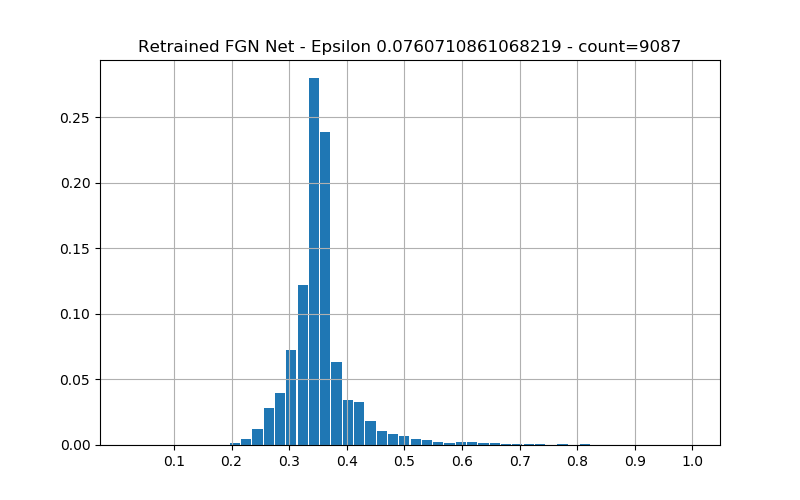

Statistical description of the predictions maximums
DescribeResult(nobs=9087, minmax=(0.115113061951295349354, 0.88959253364101053424), mean=0.35515287621291273383, variance=0.003529435977706242806, skewness=2.4229489016682238661, kurtosis=12.099284697955969704)

percentage of confident predictions (>=0.5): 0.02861230329041488

Sample predictions
index 8737 prediction [0.   0.21 0.29 0.16 0.   0.09 0.   0.22 0.   0.02]
index 868 prediction [0.01 0.04 0.09 0.37 0.01 0.26 0.   0.11 0.09 0.03]
index 1451 prediction [0.01 0.04 0.11 0.35 0.01 0.16 0.   0.11 0.15 0.06]
index 2397 prediction [0.01 0.11 0.16 0.15 0.01 0.24 0.03 0.28 0.   0.02]
index 1891 prediction [0.01 0.04 0.1  0.35 0.01 0.16 0.   0.1  0.17 0.06]


<IPython.core.display.Javascript object>


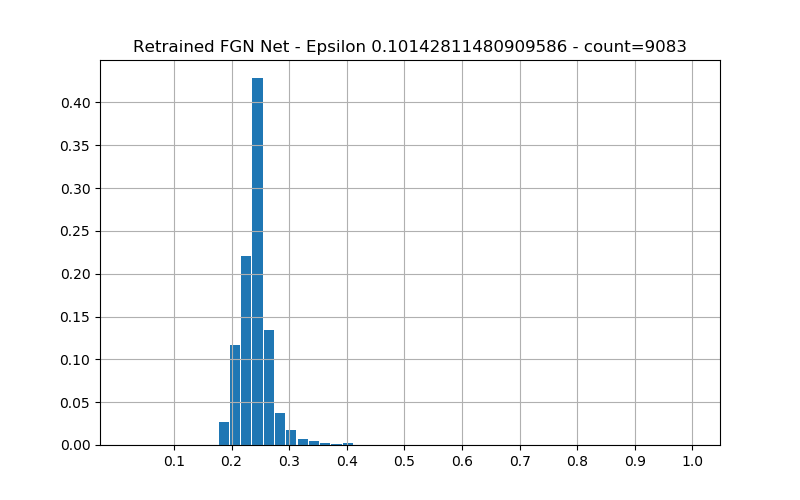

Statistical description of the predictions maximums
DescribeResult(nobs=9083, minmax=(0.11015403562866367358, 0.64484461805902428525), mean=0.24134663327159348207, variance=0.00077720422076306455044, skewness=2.114496432267189806, kurtosis=14.501195493062803017)

percentage of confident predictions (>=0.5): 0.0003302873499944952

Sample predictions
index 1868 prediction [0.01 0.08 0.13 0.26 0.03 0.21 0.02 0.16 0.06 0.05]
index 5904 prediction [0.01 0.11 0.15 0.19 0.04 0.19 0.03 0.22 0.02 0.05]
index 6049 prediction [0.01 0.1  0.12 0.24 0.03 0.18 0.02 0.16 0.06 0.06]
index 6097 prediction [0.01 0.09 0.13 0.24 0.03 0.2  0.02 0.17 0.06 0.05]
index 4795 prediction [0.01 0.14 0.14 0.19 0.03 0.18 0.04 0.21 0.02 0.05]


<IPython.core.display.Javascript object>


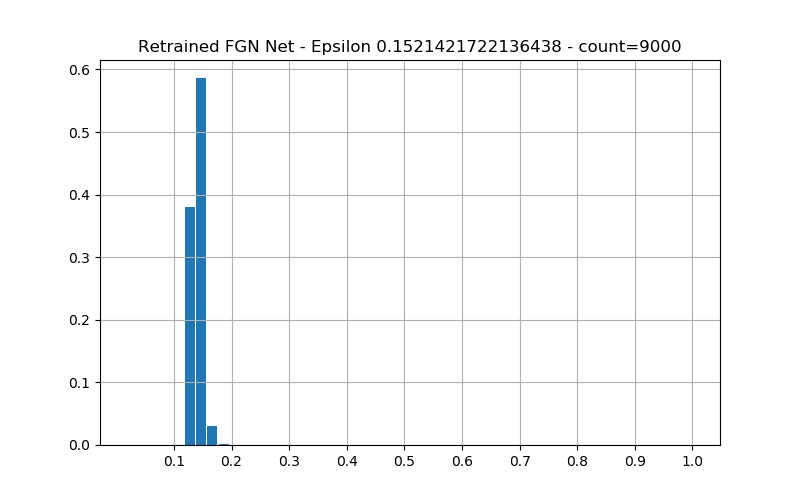

Statistical description of the predictions maximums
DescribeResult(nobs=9000, minmax=(0.10370402048752164248, 0.21901722723628204682), mean=0.14025525296434445505, variance=5.8281019527655699357e-05, skewness=1.3963908566727978098, kurtosis=5.996994114897441509)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6309 prediction [0.04 0.11 0.13 0.15 0.08 0.14 0.09 0.1  0.09 0.08]
index 7102 prediction [0.04 0.11 0.13 0.14 0.08 0.14 0.09 0.1  0.09 0.08]
index 6948 prediction [0.04 0.12 0.13 0.15 0.08 0.15 0.09 0.11 0.08 0.07]
index 4641 prediction [0.04 0.11 0.13 0.15 0.08 0.14 0.08 0.11 0.09 0.08]
index 2736 prediction [0.05 0.11 0.12 0.14 0.08 0.13 0.09 0.1  0.1  0.08]


<IPython.core.display.Javascript object>


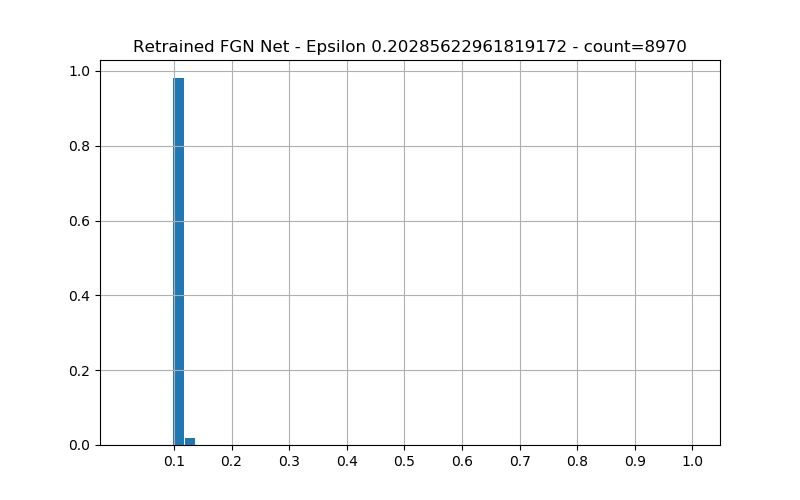

Statistical description of the predictions maximums
DescribeResult(nobs=8970, minmax=(0.10115028588285078332, 0.13993711046737359337), mean=0.10994205668229236063, variance=7.8713304716054763004e-06, skewness=1.8480465652226934828, kurtosis=8.0805976536372948835)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8216 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.1  0.09]
index 2063 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.11 0.09]
index 3158 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.1  0.09]
index 1073 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.1  0.09]
index 4387 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.1  0.09]


<IPython.core.display.Javascript object>


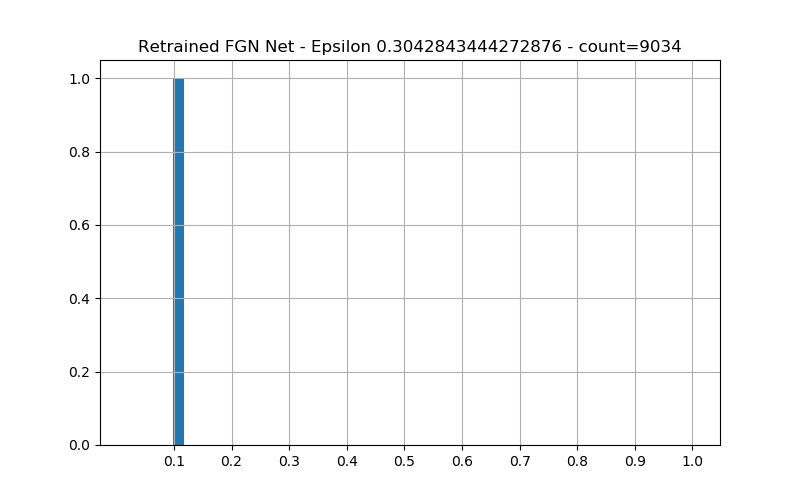

Statistical description of the predictions maximums
DescribeResult(nobs=9034, minmax=(0.100031246601965001615, 0.10436621930828109223), mean=0.10046180818960832651, variance=7.1872723649708967113e-08, skewness=3.225388887239763672, kurtosis=21.56780488832474452)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 47 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6501 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3496 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 339 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4605 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


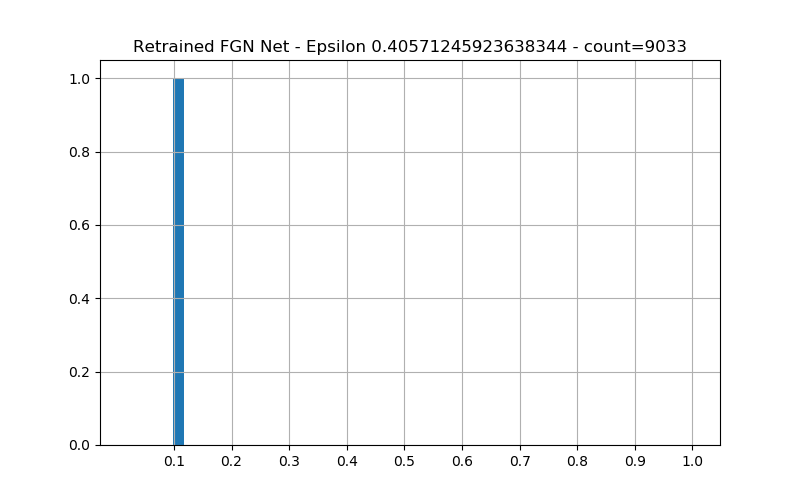

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.100000091533448676255, 0.100394294527460434594), mean=0.10000751902227022698, variance=1.4672067666824112352e-10, skewness=11.70270814798887004, kurtosis=262.44791676400761216)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 1155 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7943 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8360 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5546 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7413 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


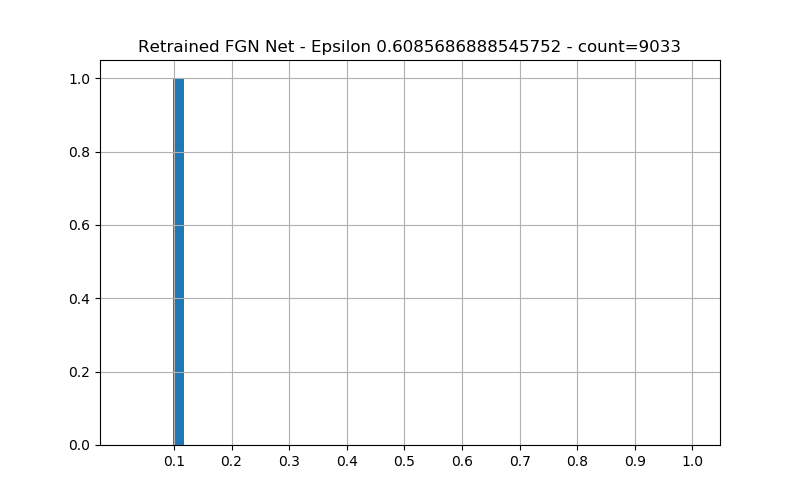

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000000000000190526, 0.10000029612363983515), mean=0.100000000250956706575, variance=2.0914113880502129677e-17, skewness=54.97868470176321122, kurtosis=3358.0912456707688838)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4765 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1521 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2785 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2863 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8797 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


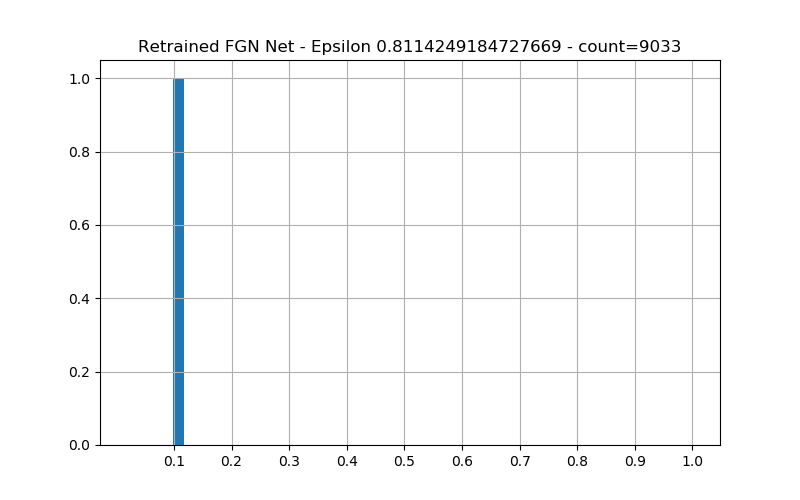

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.10000000001224238983), mean=0.10000000000000321811, variance=2.938732821137084036e-26, skewness=66.49635816485359369, kurtosis=4488.6491072468403263)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 881 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8543 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 9021 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1530 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8635 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


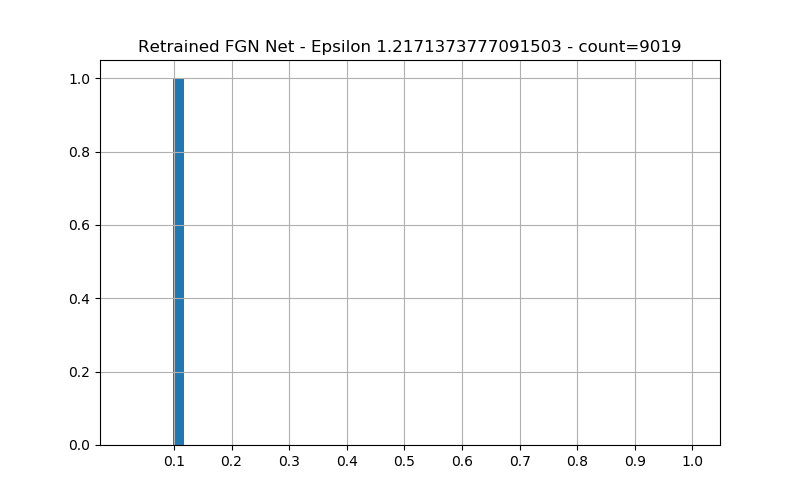

Statistical description of the predictions maximums
DescribeResult(nobs=9019, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369135946971007696e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2018 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4451 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6186 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 995 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5951 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


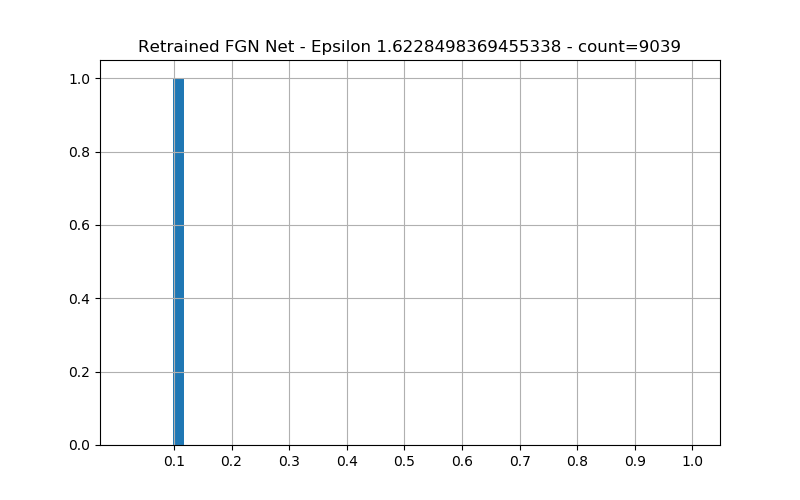

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6490 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1033 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6071 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6753 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 34 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


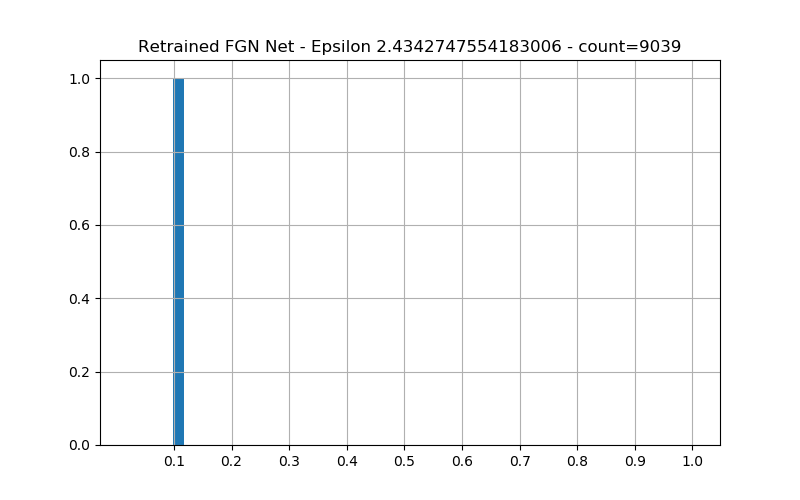

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5499 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5848 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2642 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7187 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7691 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


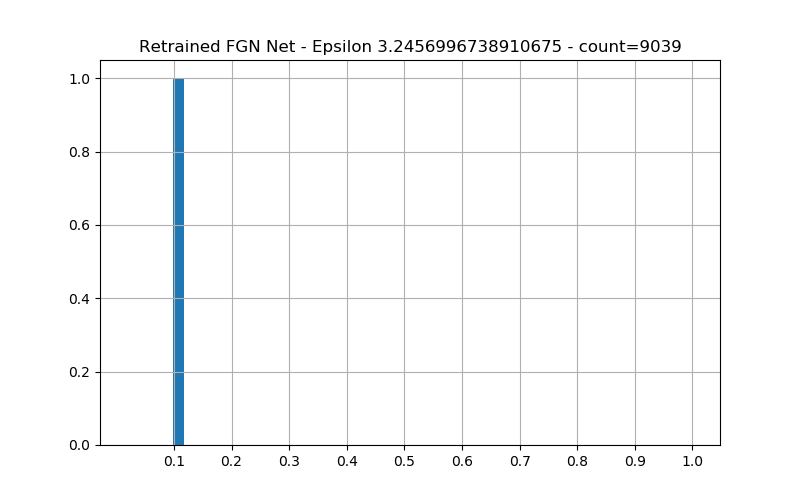

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4446 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1475 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7947 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6694 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6747 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [34]:
# rerun the ret_quick_fgn model on adv examples
for i, ret_quick_fgn_raw_images in enumerate(ret_quick_fgn_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(ret_quick_fgn_raw_images))
    t = 'Retrained FGN Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(ret_quick_fgn_model, dl, title=t, verbose=True)

<IPython.core.display.Javascript object>


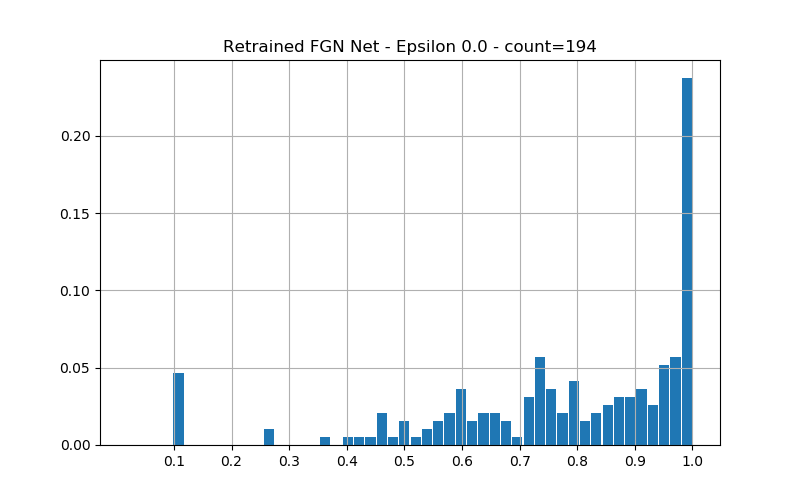

Statistical description of the predictions maximums
DescribeResult(nobs=194, minmax=(0.1, 0.9999922287610655209), mean=0.7796430900543648931, variance=0.053282290086361425764, skewness=-1.3016138509706424815, kurtosis=1.3677494961883453835)

percentage of confident predictions (>=0.5): 0.8917525773195877

Sample predictions
index 39 prediction [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
index 98 prediction [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
index 38 prediction [0.01 0.01 0.23 0.04 0.01 0.04 0.   0.05 0.16 0.44]
index 72 prediction [0.   0.94 0.   0.   0.   0.   0.   0.   0.05 0.  ]
index 180 prediction [0.   0.98 0.   0.01 0.   0.   0.   0.   0.   0.  ]


<IPython.core.display.Javascript object>


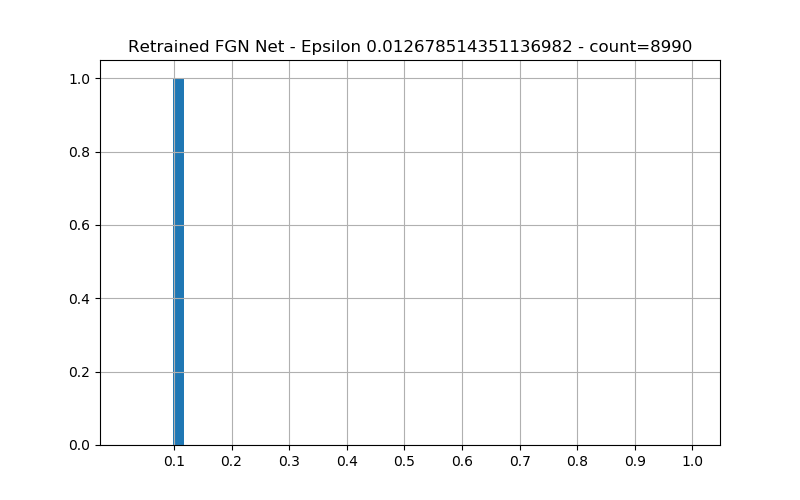

Statistical description of the predictions maximums
DescribeResult(nobs=8990, minmax=(0.1, 0.10000000000003660307), mean=0.100000000000000004535, variance=1.4920691391201220356e-31, skewness=94.63066897344624564, kurtosis=8963.321310949899911)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4311 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5428 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7107 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1014 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5291 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


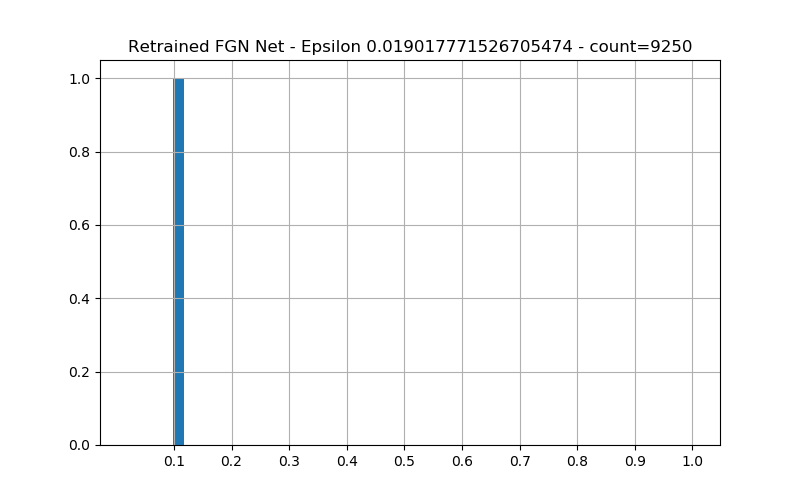

Statistical description of the predictions maximums
DescribeResult(nobs=9250, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369085078633770287e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5664 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 9133 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1241 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1717 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3483 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


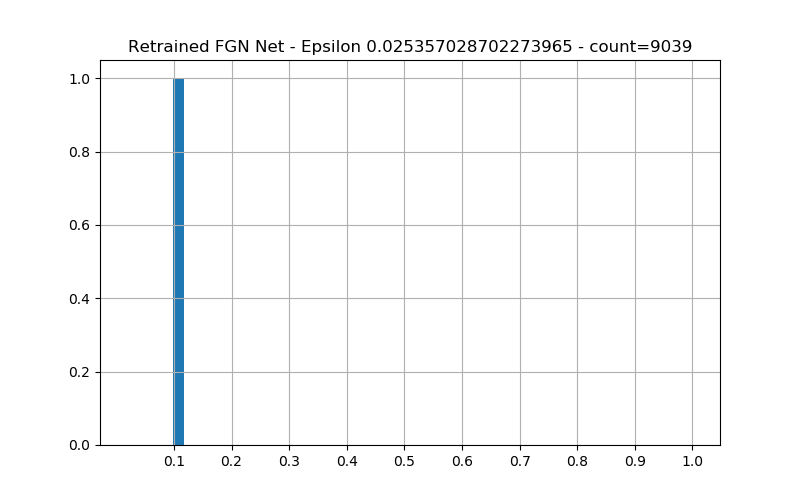

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6607 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5446 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5822 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5661 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 979 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


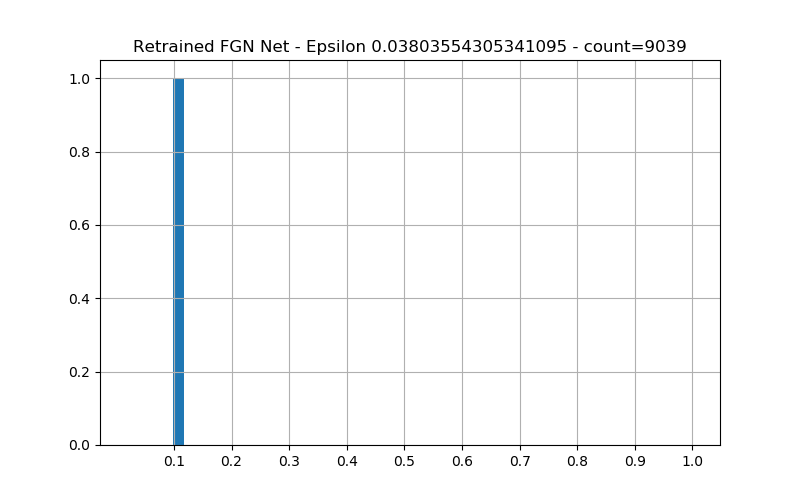

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7570 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6797 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 357 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8669 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6547 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


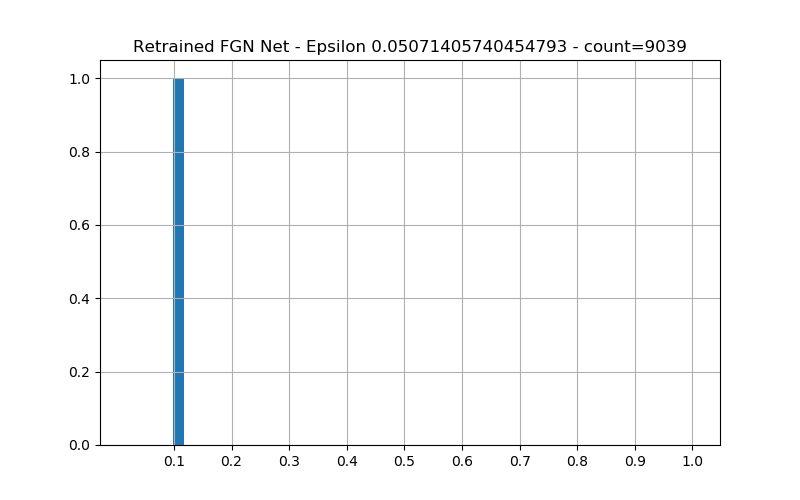

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2938 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3284 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2254 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5148 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4495 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


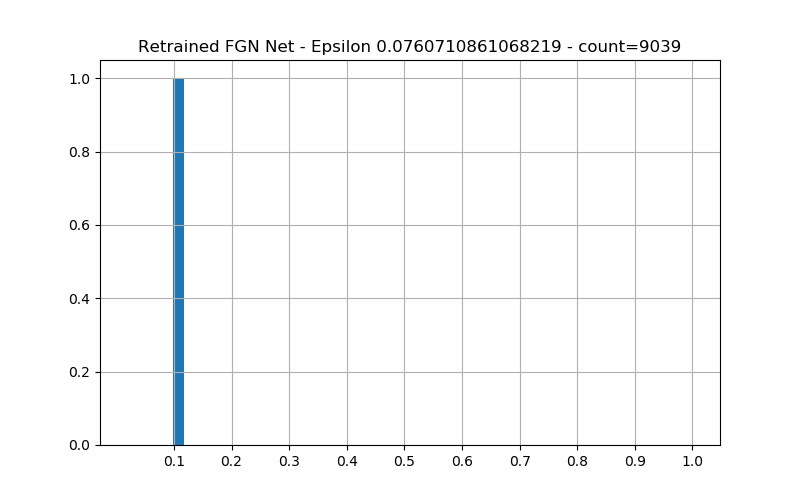

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6067 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1827 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6536 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5217 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3510 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


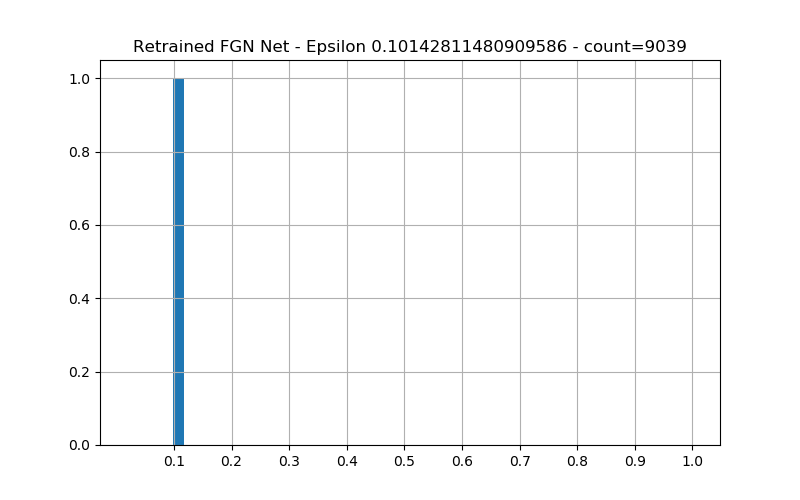

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7178 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4729 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7393 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 824 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1249 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


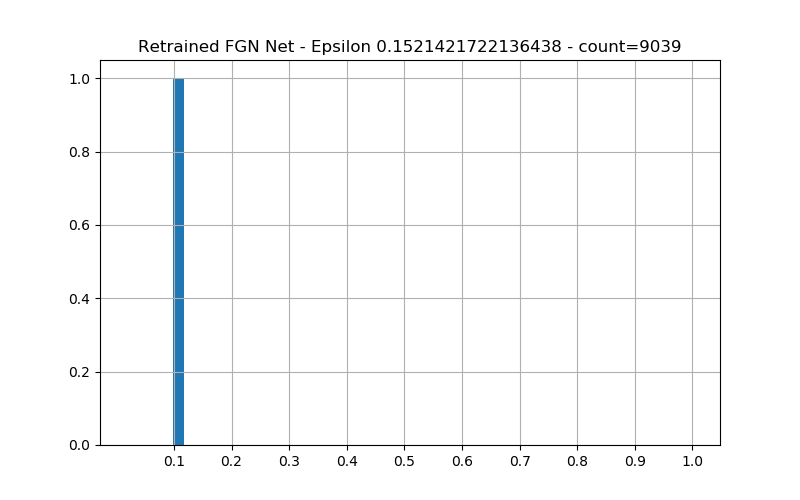

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2185 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8586 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5703 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8714 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8022 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


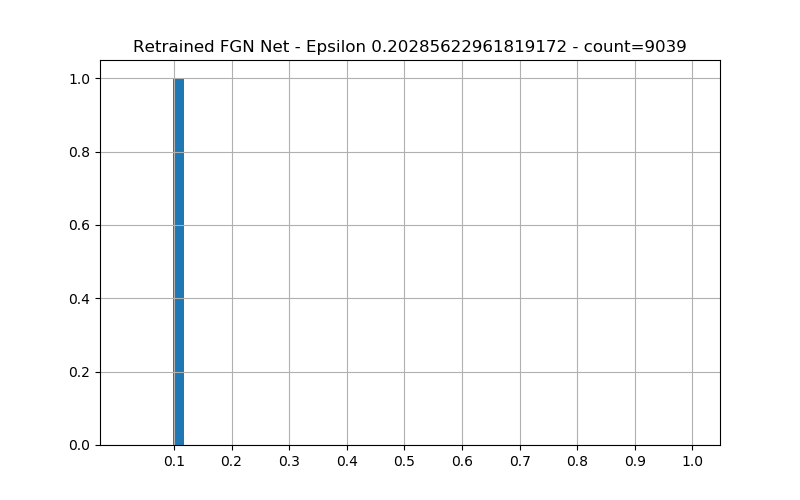

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2445 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6359 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4164 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7986 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1609 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


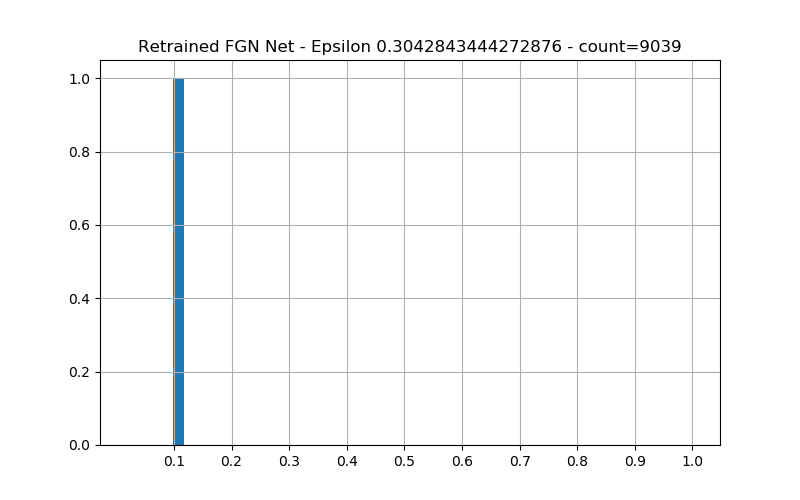

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4829 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 174 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6451 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 958 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6493 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


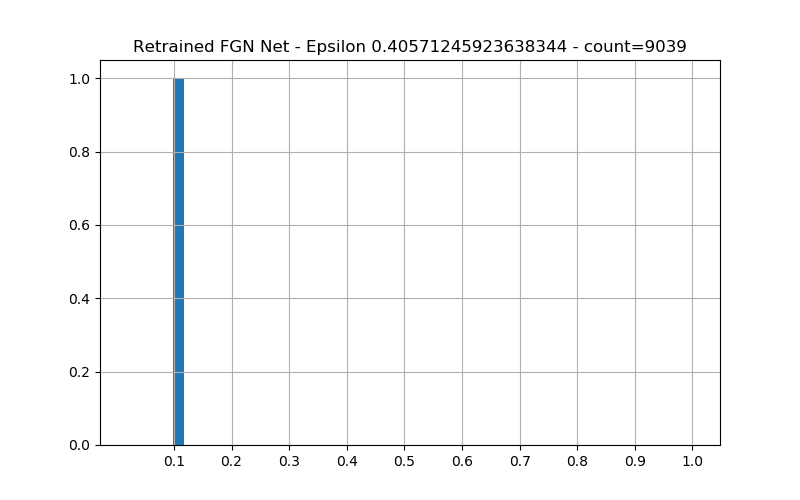

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4260 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8616 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5268 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3763 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5705 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


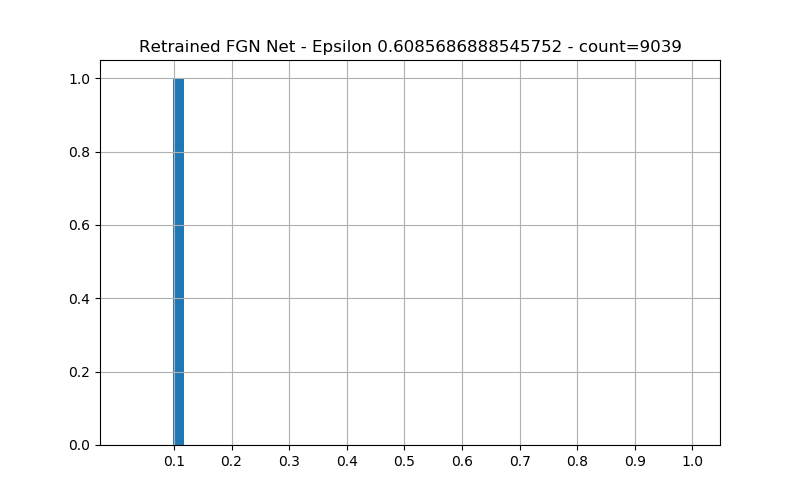

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5830 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8889 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 864 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3191 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4046 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


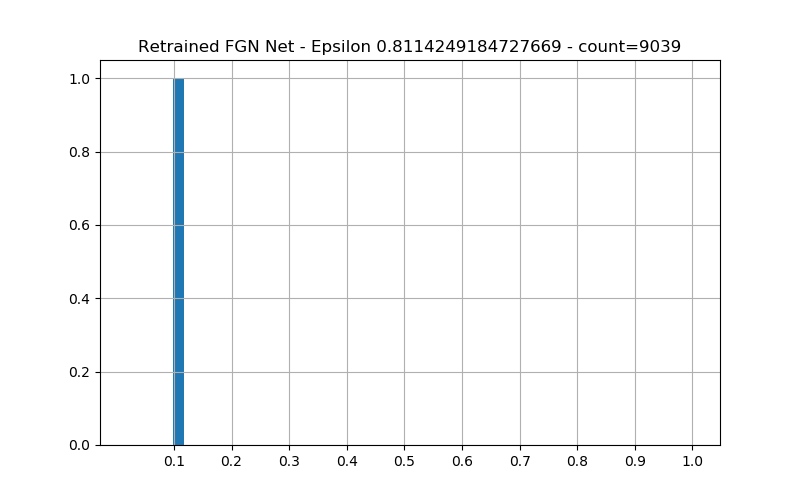

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7525 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 747 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8330 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6779 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1762 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


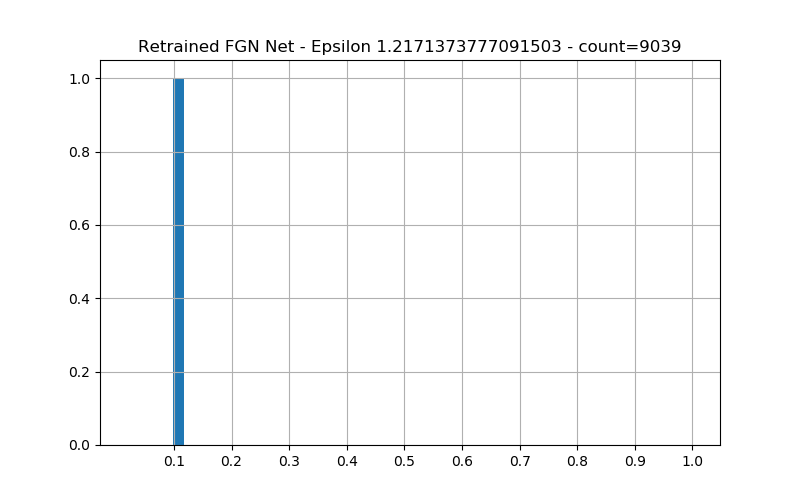

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5503 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4519 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7919 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6043 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7614 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


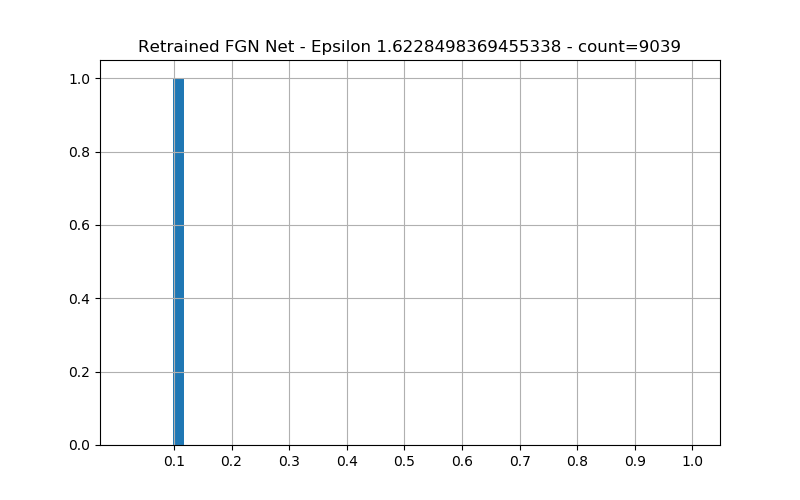

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2522 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6121 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8667 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2262 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2837 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


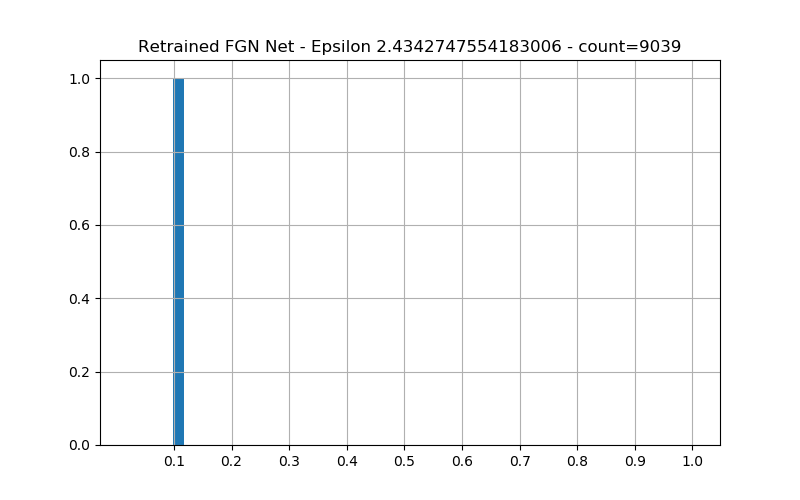

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2542 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3026 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3765 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3727 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5456 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


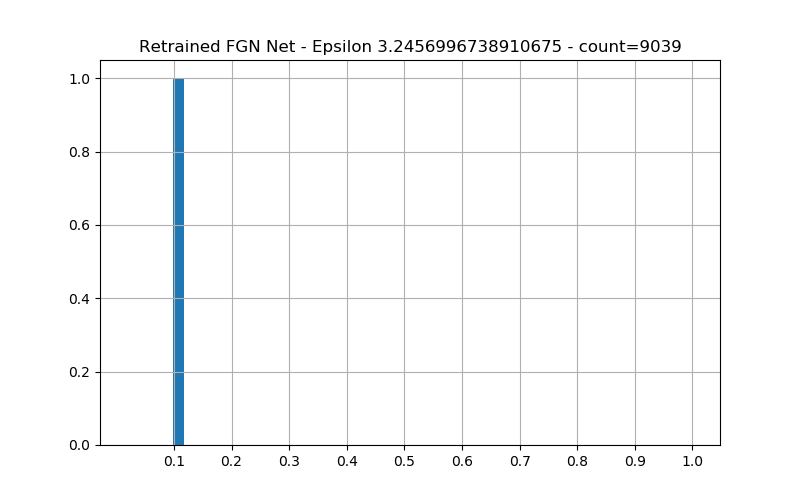

Statistical description of the predictions maximums
DescribeResult(nobs=9039, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369131439966420918e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4654 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 268 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4096 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4589 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6169 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [35]:
# rerun the ret_fgn model on adv examples
for i, ret_fgn_raw_images in enumerate(ret_fgn_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(ret_fgn_raw_images))
    t = 'Retrained FGN Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(ret_fgn_model, dl, title=t, verbose=True)

In [36]:
ret_fgn_f_model(ret_fgn_raw[1][0])

tensor([[5.5834e-19, 3.5315e-19, 7.5782e-19, 4.1429e-19, 4.4460e-19, 3.5970e-19,
         8.3319e-19, 1.9697e-19, 1.1340e-18, 3.4444e-19]])

In [37]:
labels[0]

tensor(3)

In [38]:
ret_fgn_adv_success[1][0]

tensor(True)

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


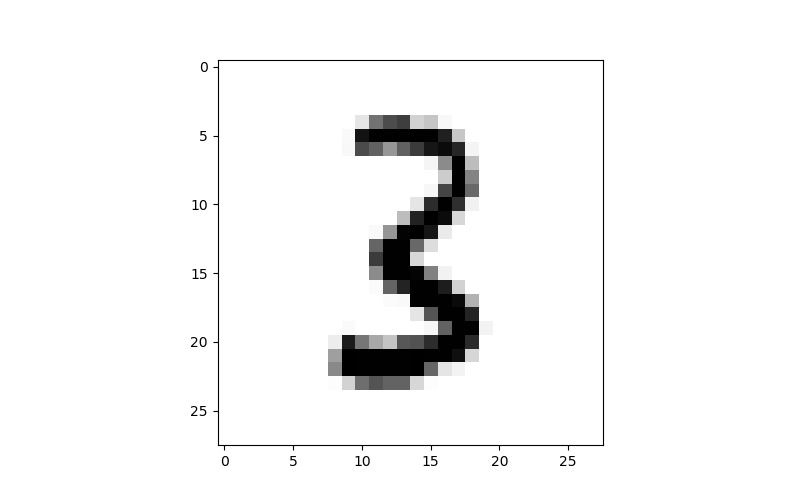

In [39]:
# original image
plt.imshow(images[0].cpu().numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


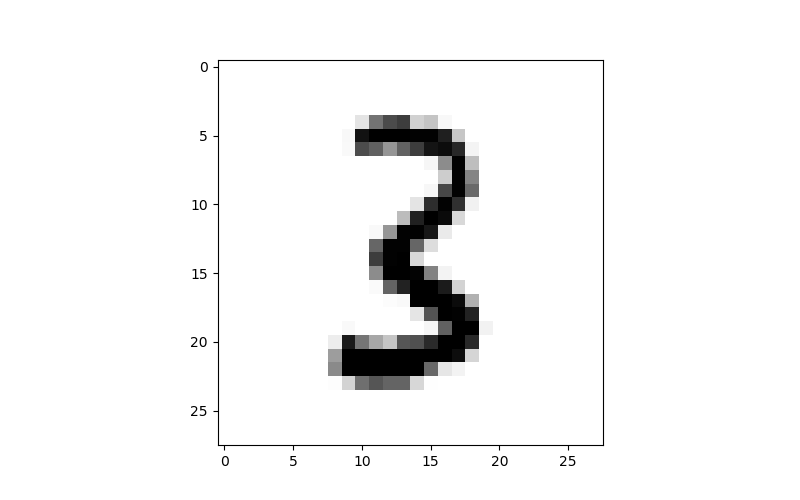

In [40]:
# adversarial image
plt.imshow(ret_fgn_raw[1][0].cpu().numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


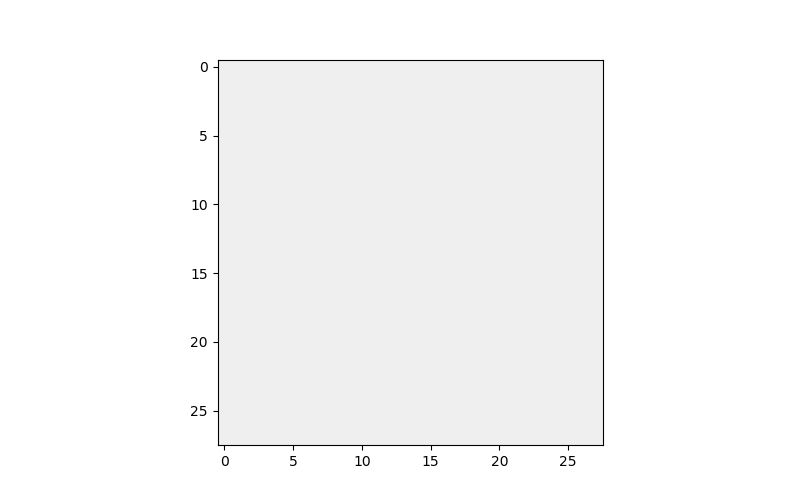

In [41]:
# noise
plt.imshow(images[0].cpu().numpy()-ret_fgn_raw[0][0].cpu().numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


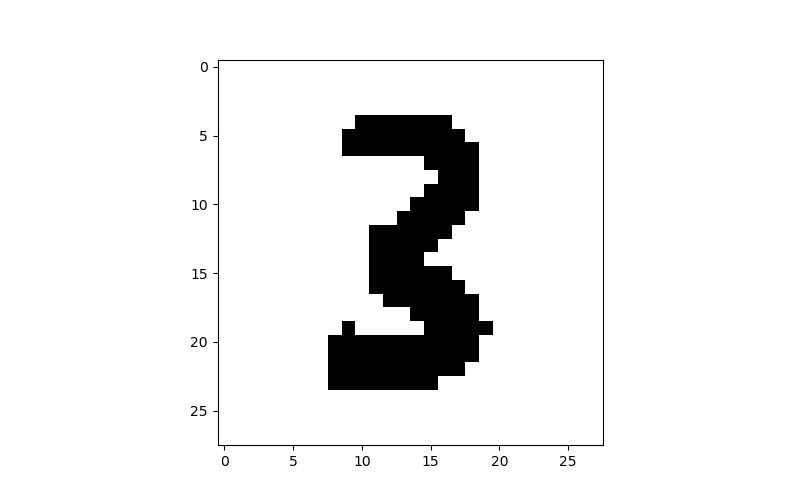

In [42]:
# noise with exagerated contrast
plt.imshow(images[0].cpu().numpy()-ret_fgn_raw[0][0].cpu().numpy(), cmap='Greys')
plt.show()

In [43]:
# compare prediction confidences 

In [44]:
names = ['classic', 'fgn', 'retrained']
al = ['right', 'mid', 'left']

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


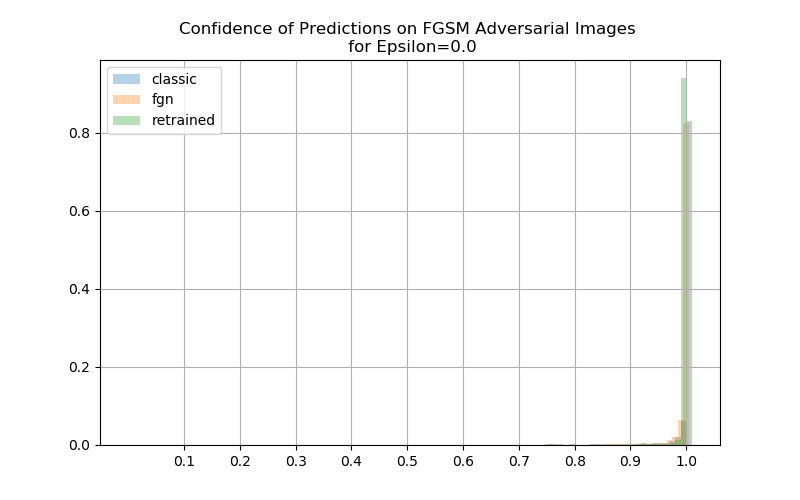

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


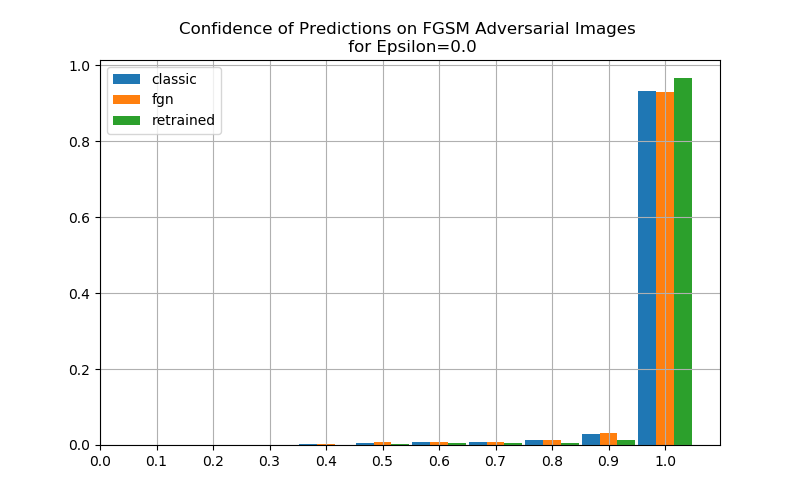

<IPython.core.display.Javascript object>


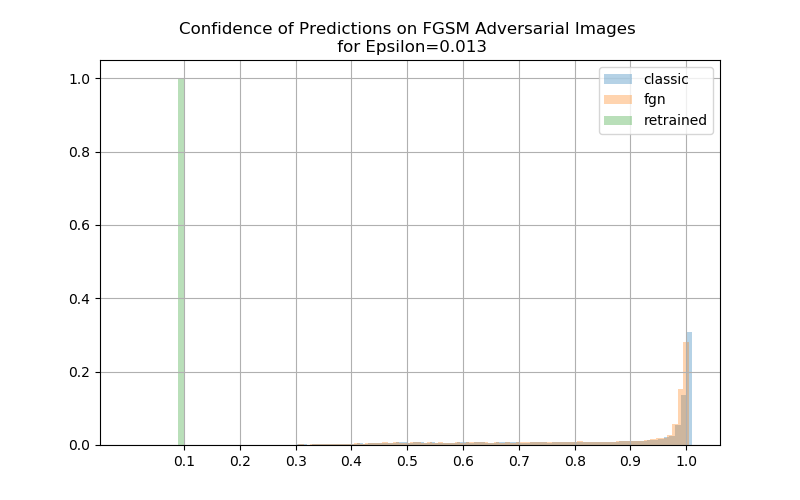

<IPython.core.display.Javascript object>


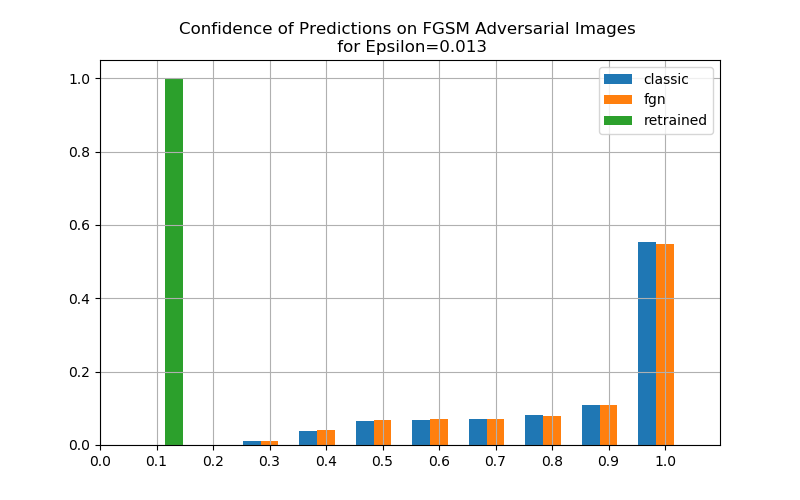

<IPython.core.display.Javascript object>


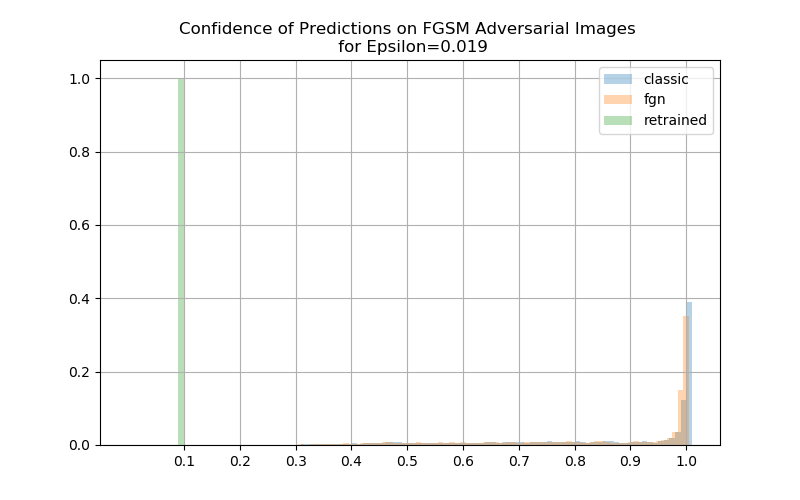

<IPython.core.display.Javascript object>


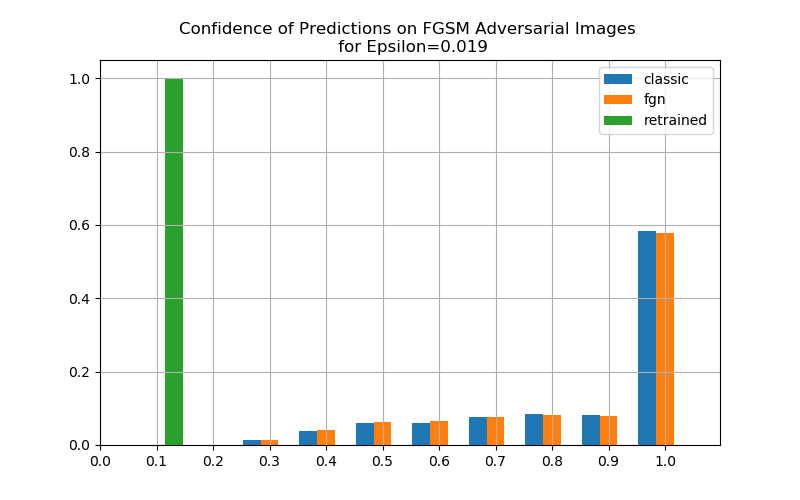

<IPython.core.display.Javascript object>


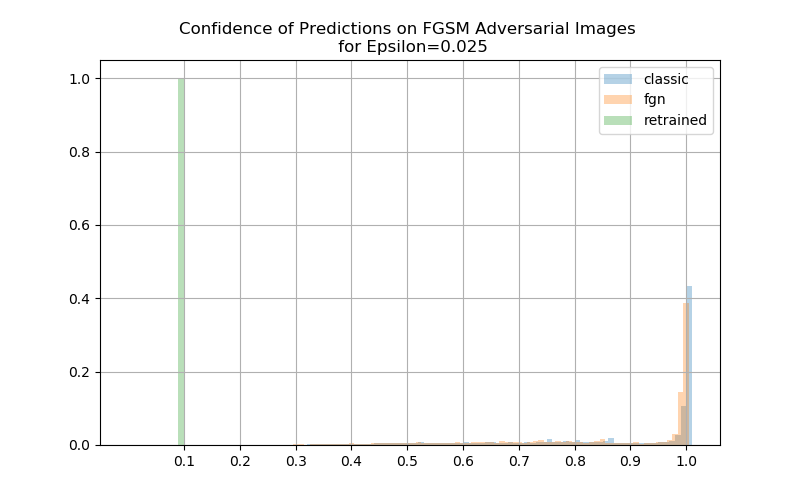

<IPython.core.display.Javascript object>


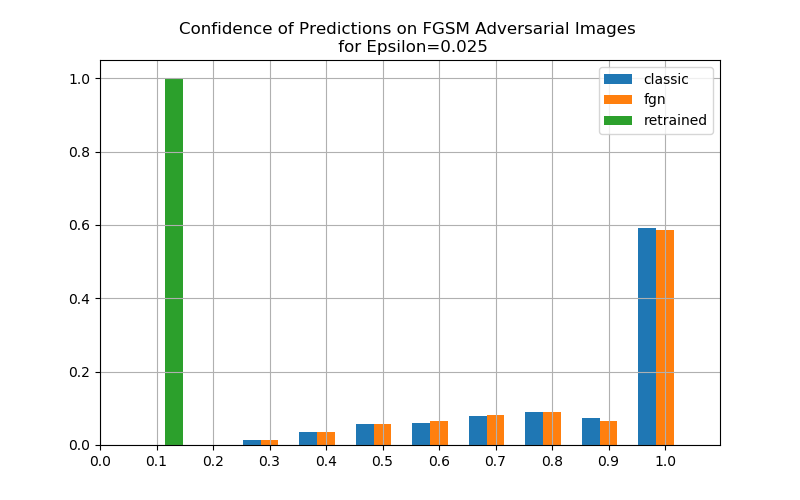

<IPython.core.display.Javascript object>


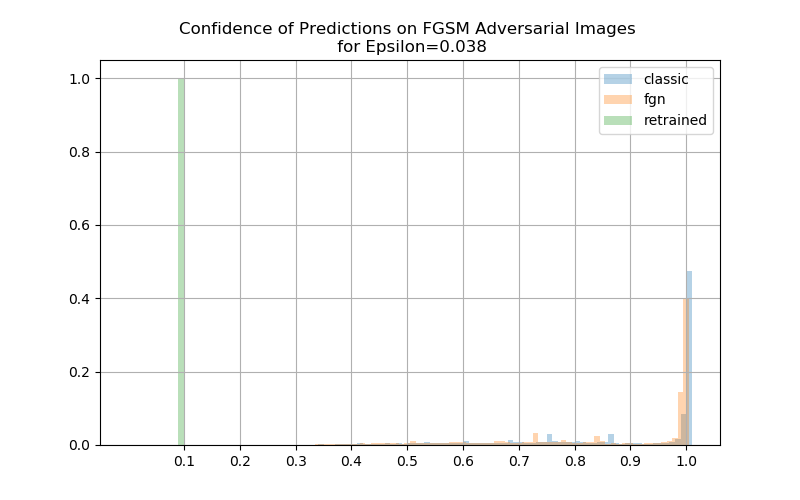

<IPython.core.display.Javascript object>


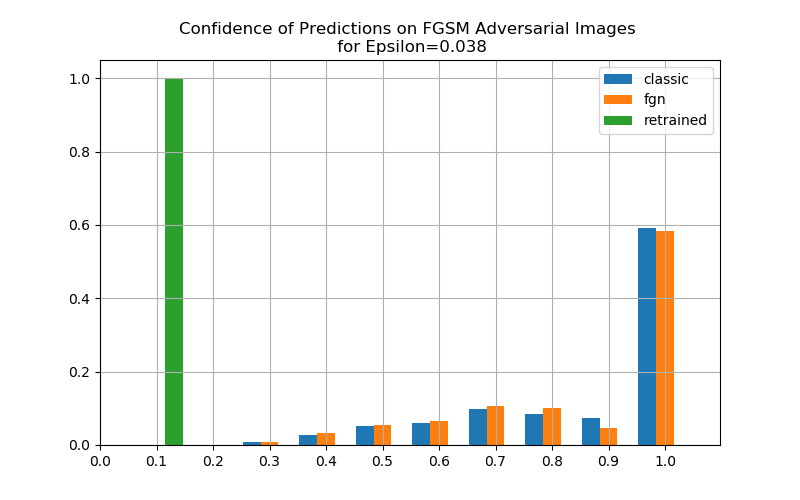

<IPython.core.display.Javascript object>


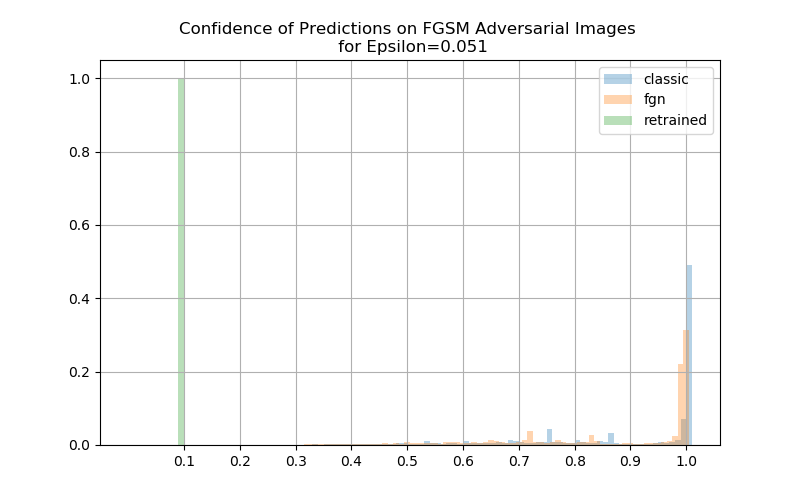

<IPython.core.display.Javascript object>


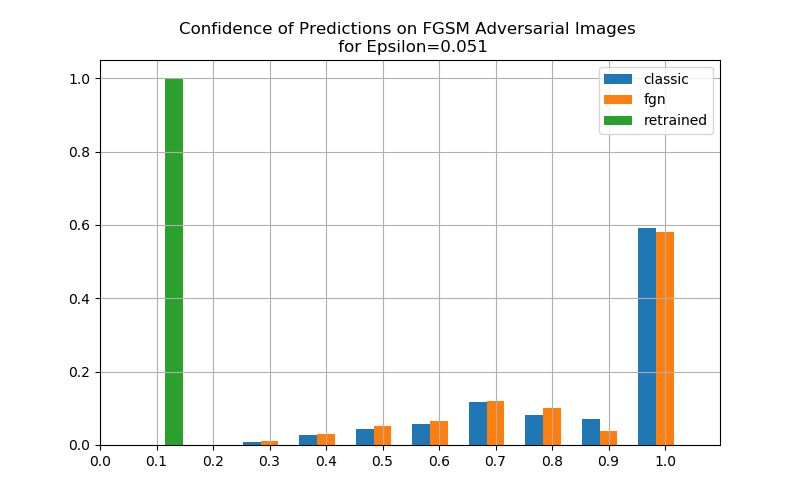

<IPython.core.display.Javascript object>


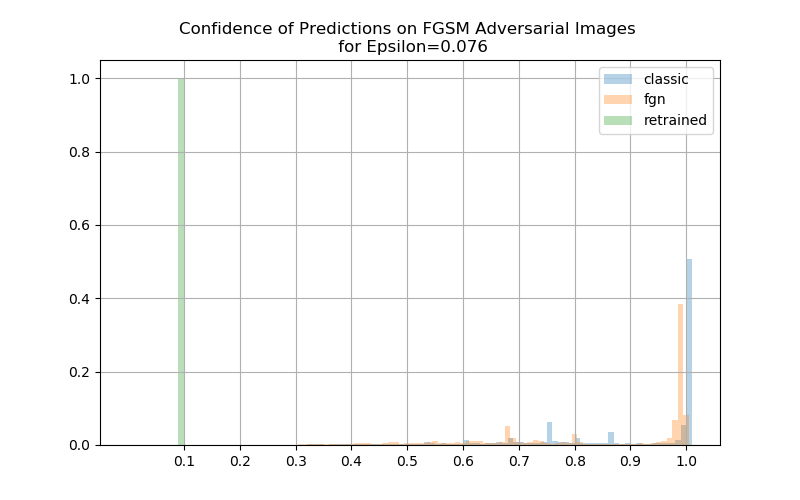

<IPython.core.display.Javascript object>


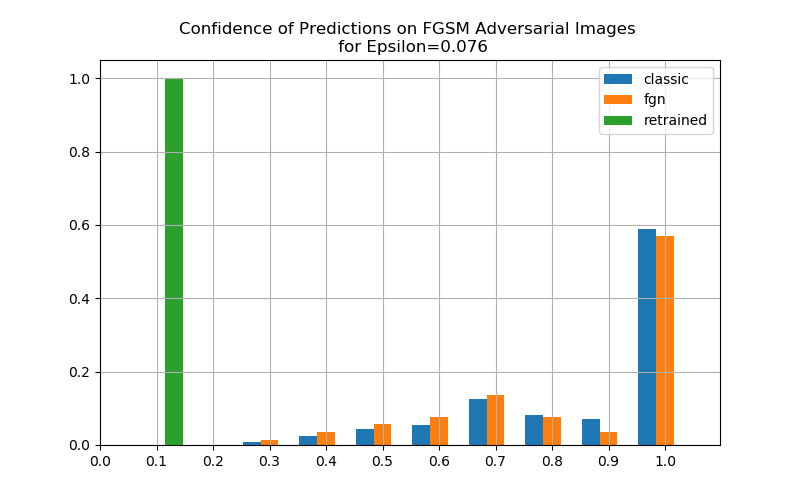

<IPython.core.display.Javascript object>


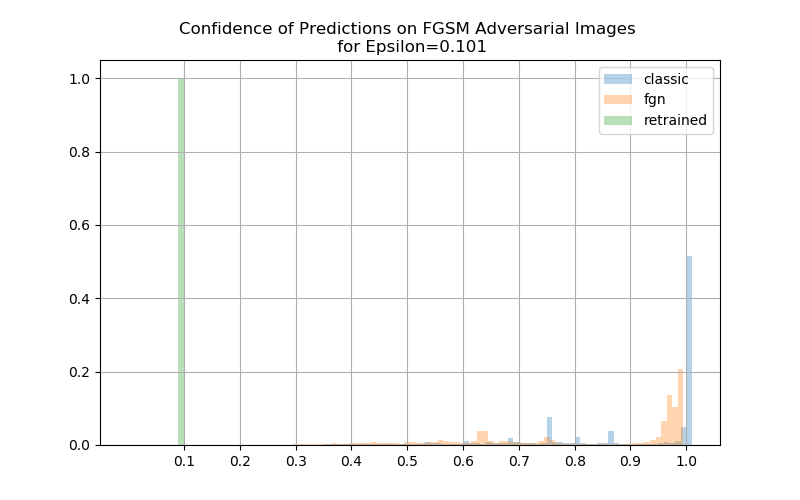

<IPython.core.display.Javascript object>


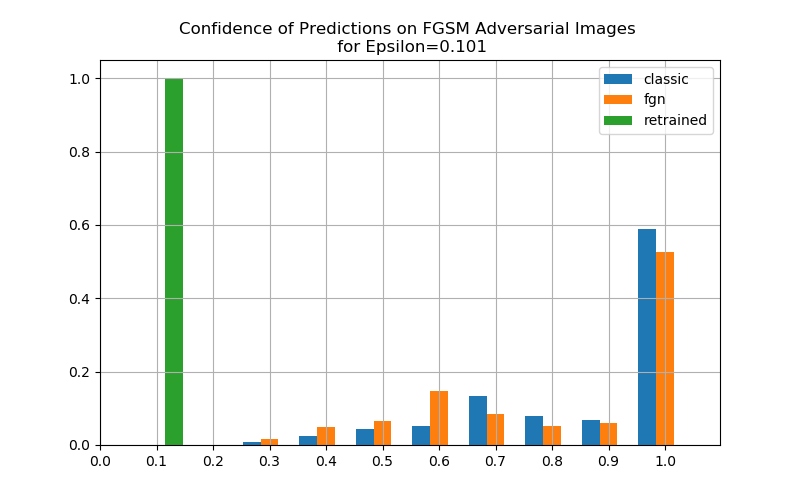

<IPython.core.display.Javascript object>


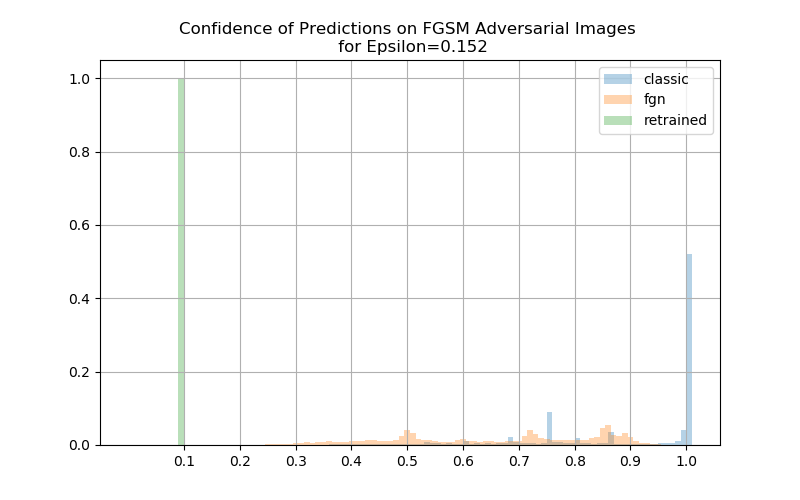

<IPython.core.display.Javascript object>


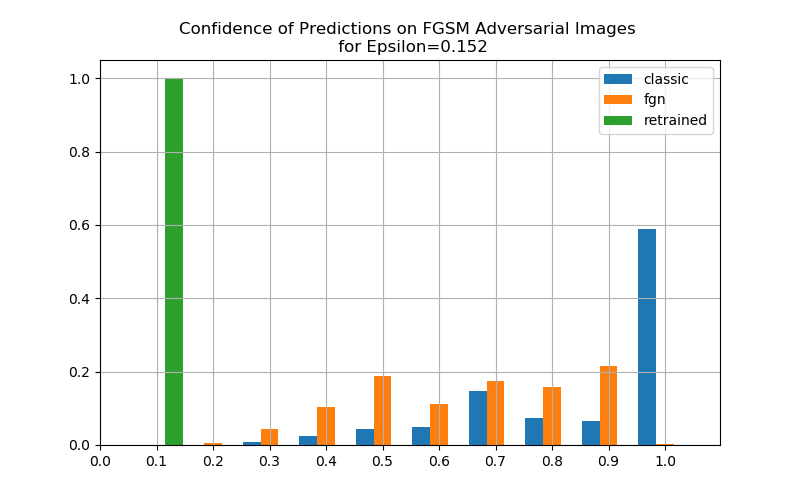

<IPython.core.display.Javascript object>


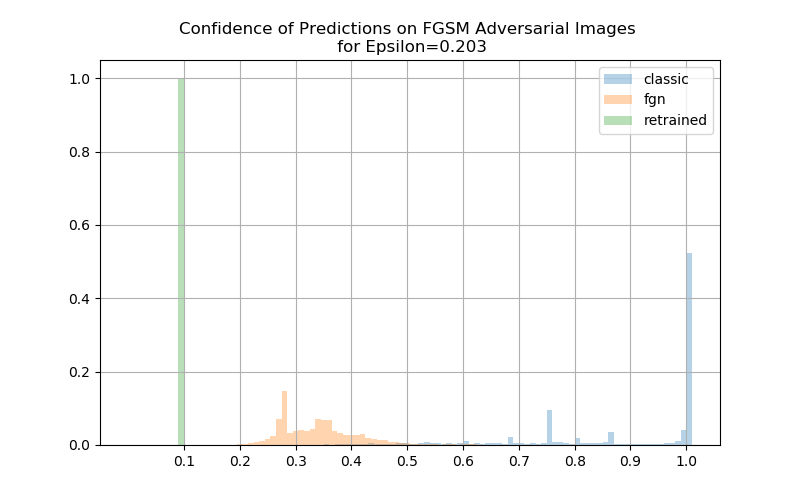

<IPython.core.display.Javascript object>


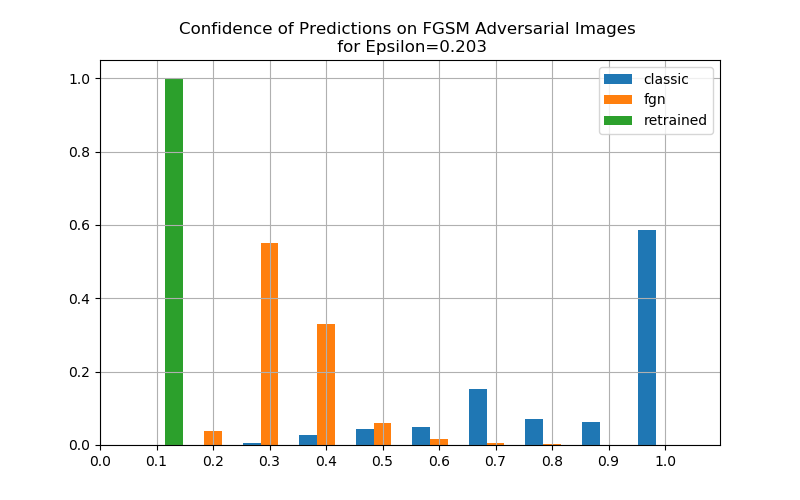

<IPython.core.display.Javascript object>


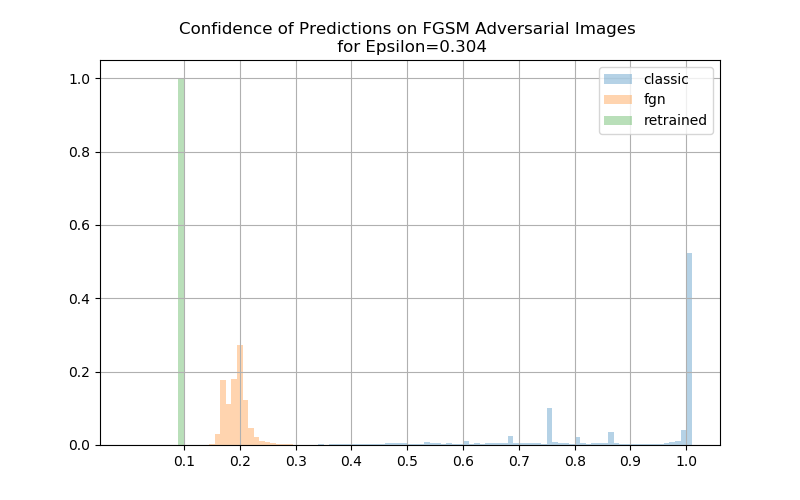

<IPython.core.display.Javascript object>


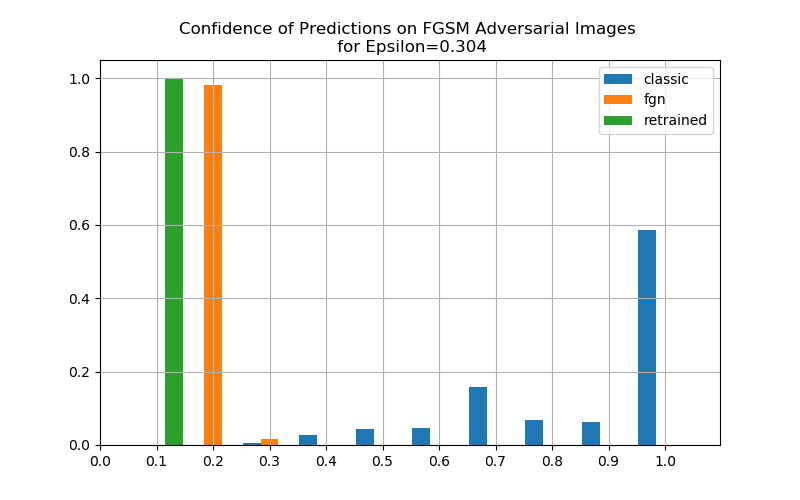

<IPython.core.display.Javascript object>


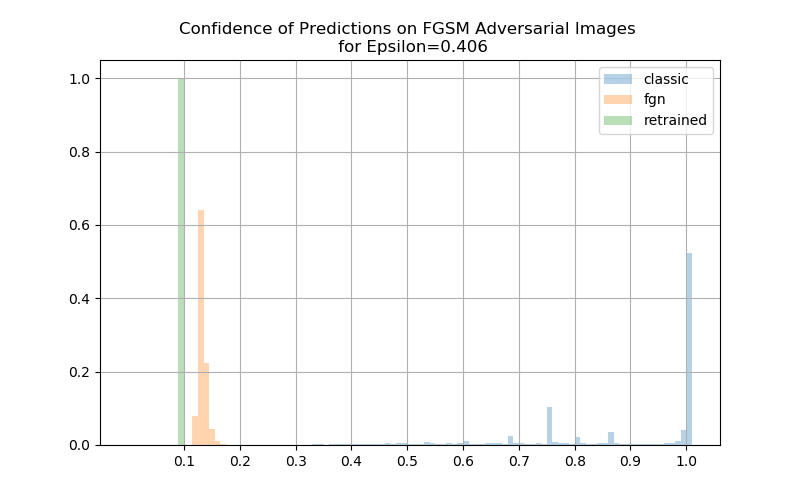

<IPython.core.display.Javascript object>


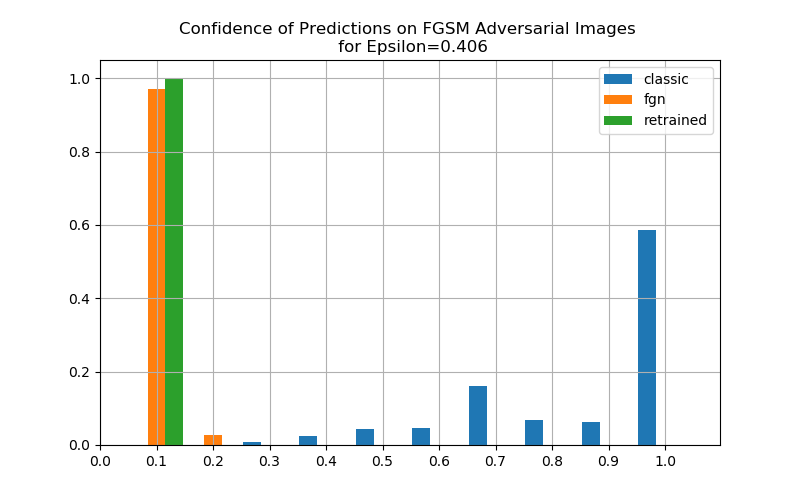

<IPython.core.display.Javascript object>


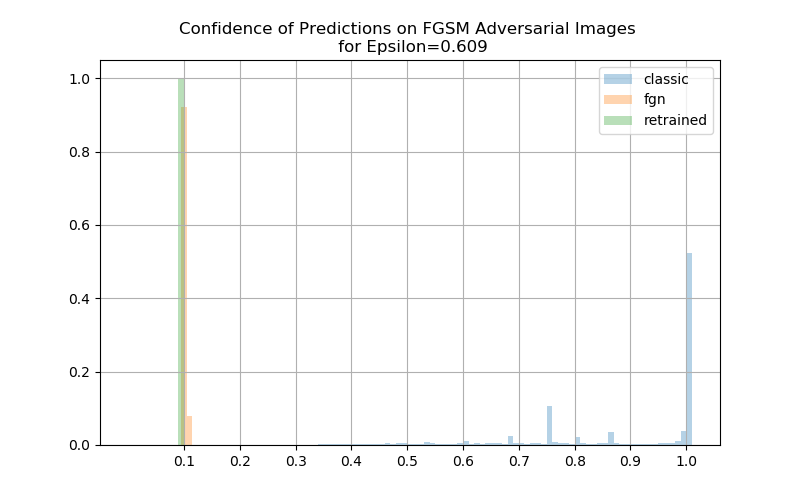

<IPython.core.display.Javascript object>


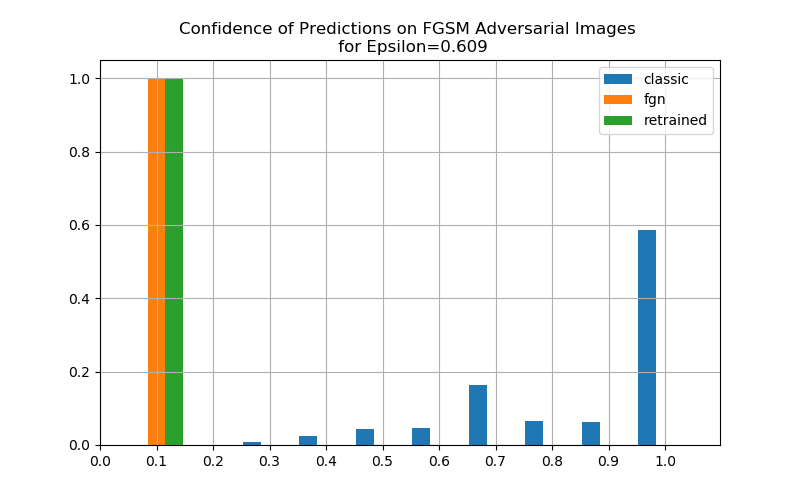

<IPython.core.display.Javascript object>


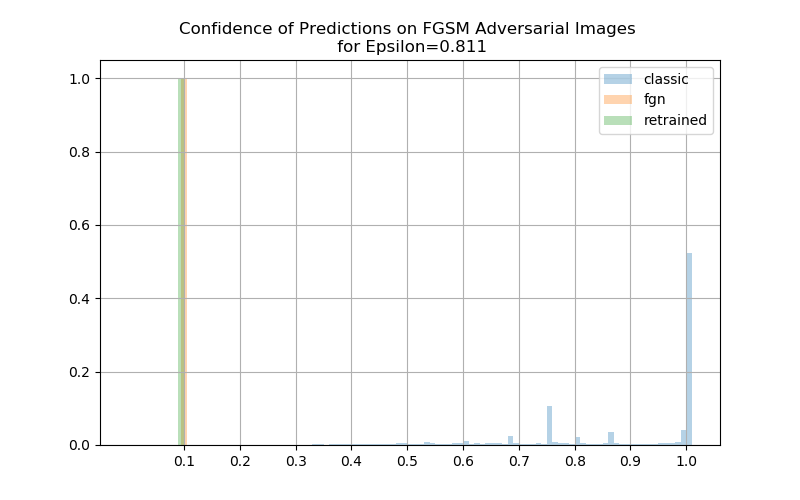

<IPython.core.display.Javascript object>


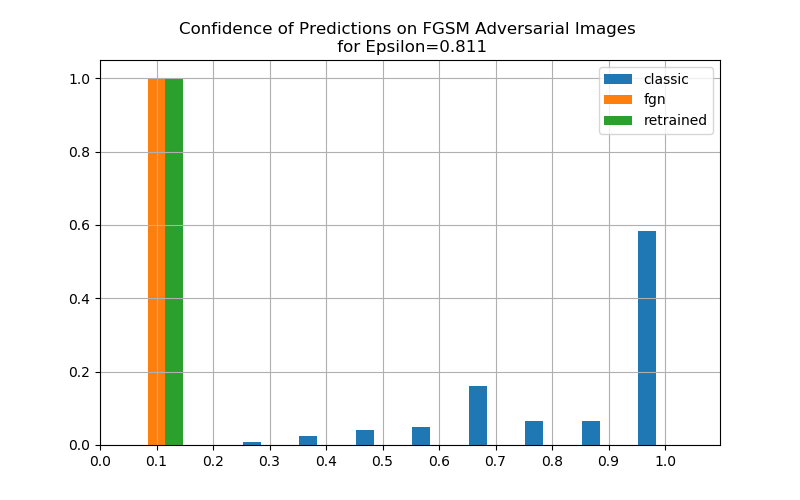

<IPython.core.display.Javascript object>


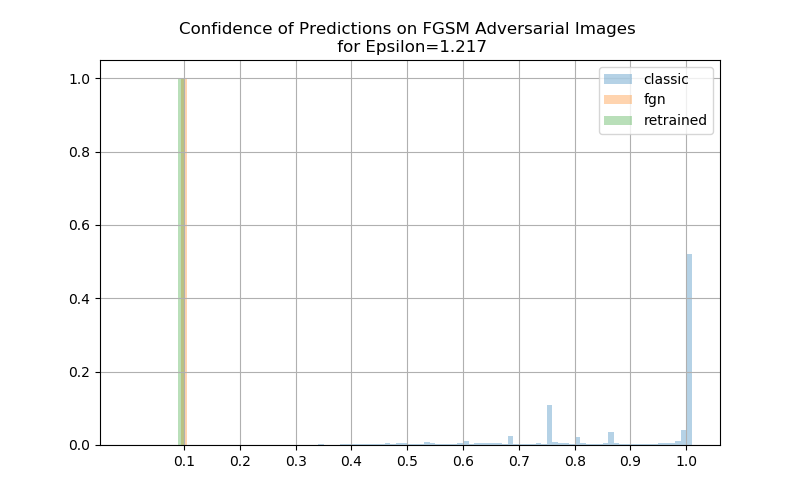

<IPython.core.display.Javascript object>


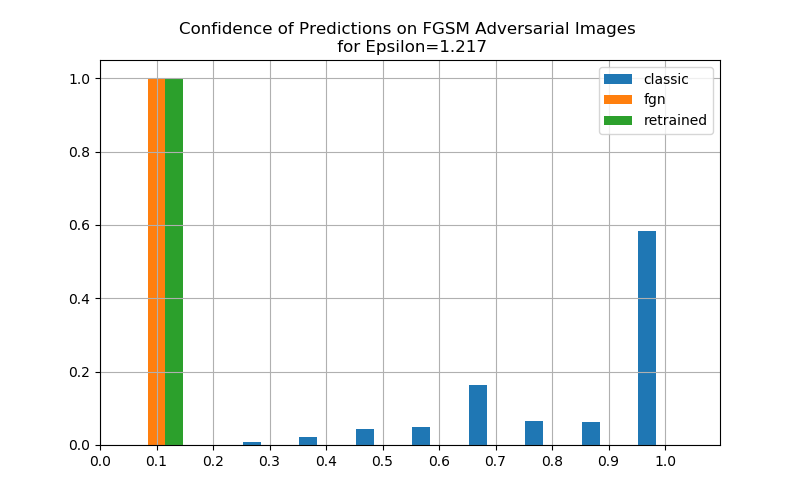

<IPython.core.display.Javascript object>


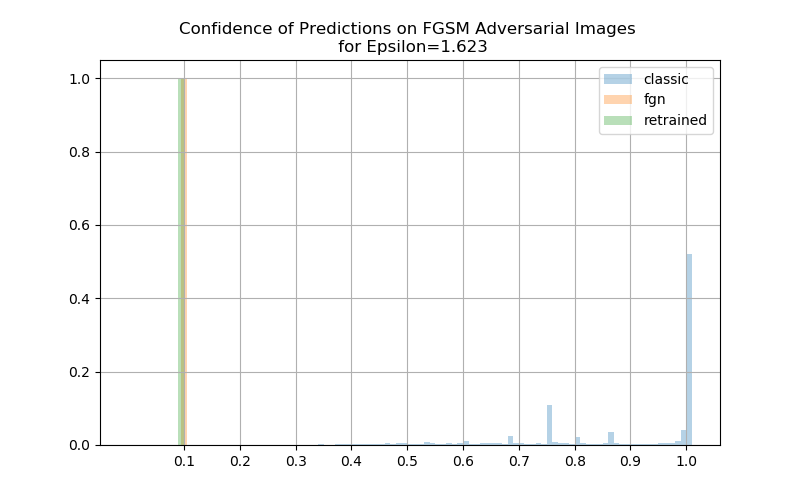

<IPython.core.display.Javascript object>


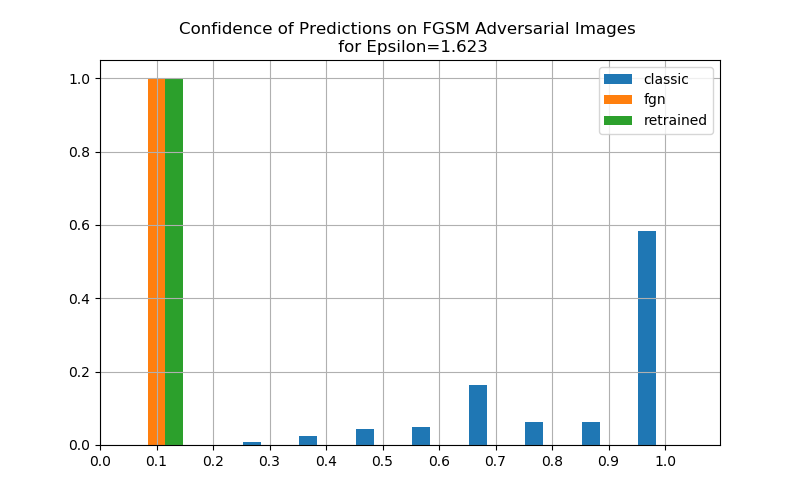

<IPython.core.display.Javascript object>


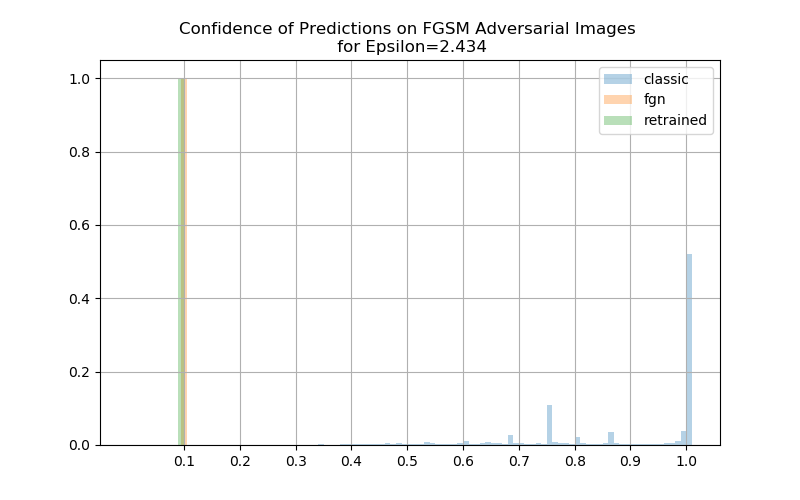

<IPython.core.display.Javascript object>


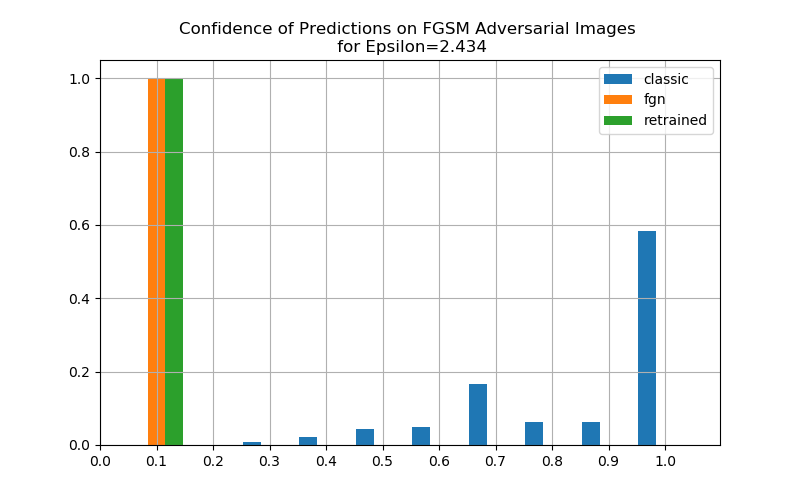

<IPython.core.display.Javascript object>


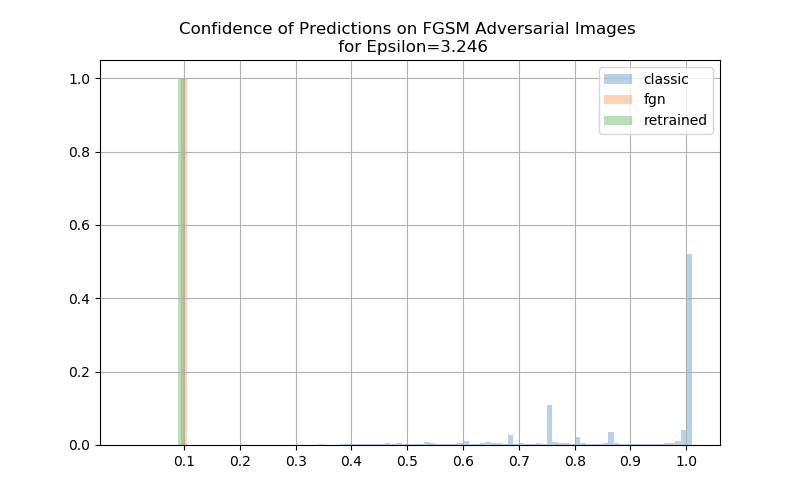

<IPython.core.display.Javascript object>


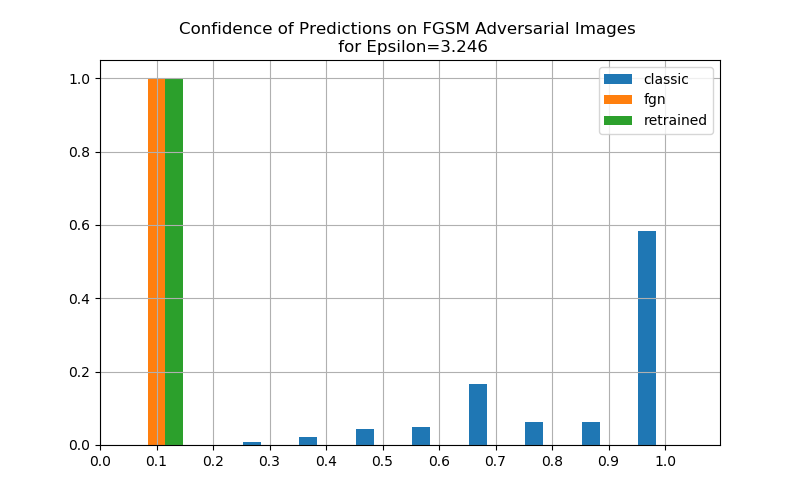

In [45]:
for i, clipped_images in enumerate(zip(classic_clipped, fgn_clipped, ret_fgn_clipped)):
    
    p = [] 
    for n, model in enumerate([classic_model, fgn_model, ret_fgn_model]):
        
        # compute predictions
        model.eval()
        with torch.no_grad(): preds = model(clipped_images[n].to(device))
        preds = preds.cpu().detach().numpy()
        
        # apply softmax for probabilities
        preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])
        # get the maximums
        preds_maxes = np.max(preds_softmax, axis=1)
        
        p.append(preds_maxes)
        
        # histogram
        plt.hist(preds_maxes,
                 bins=0.005+ np.arange(101)/100,
                 weights=[1/len(preds_maxes) for _ in preds_maxes], 
                 rwidth=1.2,
                 label=names[n],
                 align=al[n], 
                 alpha=0.33)
    plt.xticks((np.arange(10)+1)/10.0)
    plt.legend()
    plt.title('Confidence of Predictions on FGSM Adversarial Images \n for Epsilon={}'.format(np.round(epsilons[i],3)) )
    plt.grid(True)
    plt.show()
        
        
    # histogram
    # weights = np.ones_like(preds_maxes)/len(preds_maxes)
    plt.hist(p, bins= 0.05+ np.arange(11)/10,
             rwidth=0.95, weights=[[1/len(p[0]) for _ in p[0]] for _ in p],
             align='mid',
             label=names )
    plt.xticks(np.arange(11)/10.0)
    plt.legend()
    plt.title('Confidence of Predictions on FGSM Adversarial Images \n for Epsilon={}'.format(np.round(epsilons[i],3)) )
    plt.grid(True)
    plt.show()